# CHL Data Exploration
Notebook to explore the available MULTI, OLCI L2 and OLCI L3 data for the three subareas

In [ ]:
# import all necessary libraries
import os
from datetime import datetime, timedelta
import getpass
import xarray as xr
!python -m pip install motuclient==1.8.4 --no-cache-dir
import motuclient
import xarray as xr
import numpy as np
!python -m pip install ffmpeg==1.4
import matplotlib.pyplot as plt
import matplotlib
import subprocess
import pandas as pd
!python -m pip install rioxarray
import rioxarray
import rasterio as rio
import rasterio.plot
!python -m pip install netCDF4
import netCDF4
!python -m pip install h5netcdf
import h5netcdf
import random
from skimage import io as skio
import ffmpeg
import matplotlib.gridspec as gridspec
import subprocess
from sklearn.neighbors import KernelDensity
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
#from numba import jit, cuda
import tifffile
from tqdm import tqdm
import skimage.transform as sktransform
import tensorflow as tf
!pip install dask==2022.12.1
import dask
!pip install basemap
from mpl_toolkits.basemap import Basemap
import pandas as pd
from bokeh.io import output_notebook, show
from bokeh.plotting import gmap
from bokeh.models import GMapOptions, Rect
import dotenv
dotenv.load_dotenv("dev.env")
output_notebook()

  Preparing metadata (setup.py) ... done
  Created wheel for motuclient: filename=motuclient-1.8.4-py3-none-any.whl size=32873 sha256=516c2a8f41d72d9cedc33cce629be439e8a4cc96d7baf7a3dd33545e66e6da1e
  Stored in directory: /tmp/pip-ephem-wheel-cache-s36v_1yb/wheels/46/74/d1/ee3216f52d83212f10a0a5f5b94f3d99cf3d29b8ecf09c60b6
Successfully built motuclient
  Preparing metadata (setup.py) ... done
  Created wheel for ffmpeg: filename=ffmpeg-1.4-py3-none-any.whl size=6083 sha256=6f4d7e1c7b27ffc0b868d48e646e9d6687ce5437261c8a3d4f7821a213e10249
  Stored in directory: /root/.cache/pip/wheels/8e/7a/69/cd6aeb83b126a7f04cbe7c9d929028dc52a6e7d525ff56003a
Successfully built ffmpeg
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.5/53.5 kB 5.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.3/21.3 MB 36.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.4/5.4 MB 67.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 66.4 MB/s eta 0:00:00
     

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Plot the map with the research areas

In [ ]:
api_key = os.getenv('GOOGLE_API_KEY')

bokeh_width, bokeh_height = 700,750
lat, lon = 60, 20

def plot(lat, lng, zoom=5, map_type='roadmap'):
    gmap_options = GMapOptions(lat=lat, lng=lng, map_type=map_type, zoom=zoom)
    p = gmap(api_key, gmap_options, title='Baltic Sea', width=bokeh_width, height=bokeh_height)

    # Define the rectangle coordinates
    rect_coords = [(59, 20), (60, 21)]  # Example coordinates, adjust as needed

    # Add the rectangles to the plot
    p.rect(x=rect_coords[0][1], y=rect_coords[0][0], width=rect_coords[1][1] - rect_coords[0][1],
           height=rect_coords[1][0] - rect_coords[0][0], fill_alpha=0.5, fill_color='red')

    show(p)
    return p

p = plot(lat, lon)

Load all data into the notebook, reproject and resample the mask data and then use the mask to only keep the data of the Baltic Sea for further analysis

In [ ]:
valuesRiga_dir = r'/content/drive/MyDrive/MasterThesis/Data/CHL_1km/values_Riga'
valuesKattegat_dir = r'/content/drive/MyDrive/MasterThesis/Data/CHL_1km/values_Kattegat'
valuesGotland_dir = r'/content/drive/MyDrive/MasterThesis/Data/CHL_1km/values_Gotland'
chl_dir_olci = r'/content/drive/MyDrive/MasterThesis/Data/CHL_300m'
chl_dir_olci_L2 = r'/content/drive/MyDrive/MasterThesis/Data/CHL_olci'

chl_dir = r'/content/drive/MyDrive/MasterThesis/Data/CHL_1km'
mask_dir = r'/content/drive/MyDrive/MasterThesis/Data/land_mask/iowtopo2_rev03.nc'

In [ ]:
# load the multi data from file
chl_array_multi_RIGA = np.empty((0,160,160))
for i in range(9):
  file = f'CHL_data_multi_{i}.npy'
  txt = np.load(f'{valuesRiga_dir}/{file}')
  chl_array_multi_RIGA= np.append(chl_array_multi_RIGA, txt, axis=0)



# load the multi data from file
chl_array_multi_KTT = np.empty((0,160,160))
for i in range(9):
  file = f'CHL_data_multi_{i}.npy'
  txt = np.load(f'{valuesKattegat_dir}/{file}')
  chl_array_multi_KTT= np.append(chl_array_multi_KTT, txt, axis=0)

# load the multi data from file
chl_array_multi_GTL = np.empty((0,160,160))
for i in range(9):
  file = f'CHL_data_multi_{i}.npy'
  txt = np.load(f'{valuesGotland_dir}/{file}')
  chl_array_multi_GTL= np.append(chl_array_multi_GTL, txt, axis=0)

# Define expected time range multi
multi_times = pd.date_range(start='1997-09-04', end='2021-12-31', freq='D')

# load the olci data from file
chl_array_olci_RIGA = np.empty((0,160,160))
for i in range(7, 15, 1):
  file = f'CHL_data_{i}.npy'
  txt = np.load(f'{valuesRiga_dir}/{file}')
  chl_array_olci_RIGA= np.append(chl_array_olci_RIGA, txt, axis=0)

chl_array_olci_RIGA_nothreshold = np.empty((0,160,160))
for i in range(7, 15, 1):
  file = f'CHL_data_olci_nothreshold_{i}.npy'
  txt = np.load(f'{valuesRiga_dir}/{file}')
  chl_array_olci_RIGA_nothreshold= np.append(chl_array_olci_RIGA_nothreshold, txt, axis=0)


# load the olci data from file
chl_array_olci_KTT = np.empty((0,160,160))
for i in range(7, 15, 1):
  file = f'CHL_data_{i}.npy'
  txt = np.load(f'{valuesKattegat_dir}/{file}')
  chl_array_olci_KTT= np.append(chl_array_olci_KTT, txt, axis=0)

# load the olci data from file
chl_array_olci_GTL = np.empty((0,160,160))
for i in range(7, 15, 1):
  file = f'CHL_data_{i}.npy'
  txt = np.load(f'{valuesGotland_dir}/{file}')
  chl_array_olci_GTL= np.append(chl_array_olci_GTL, txt, axis=0)


# Define expected time range olci
olci_times = pd.date_range(start='2016-05-01', end='2023-04-15', freq='D')

In [ ]:
file = f'CHL_data_olci_nothreshold_7.npy'
txt = np.load(f'{valuesRiga_dir}/{file}')
txt

array([[[      nan,       nan,       nan, ...,       nan,       nan,
               nan],
        [      nan,       nan,       nan, ...,       nan,       nan,
               nan],
        [      nan,       nan,       nan, ...,       nan,       nan,
               nan],
        ...,
        [2.3931923, 2.91623  , 2.3636696, ...,       nan,       nan,
               nan],
        [2.2415476, 4.022581 , 2.2041192, ...,       nan,       nan,
               nan],
        [3.2769387, 2.6408315, 2.870801 , ...,       nan,       nan,
               nan]],

       [[      nan,       nan,       nan, ...,       nan,       nan,
               nan],
        [      nan,       nan,       nan, ...,       nan,       nan,
               nan],
        [      nan,       nan,       nan, ...,       nan,       nan,
               nan],
        ...,
        [      nan,       nan,       nan, ...,       nan,       nan,
               nan],
        [      nan,       nan,       nan, ...,       nan,       nan,
   

In [ ]:
# load olci L2 data
chl_array_olci_L2 = np.load(f'{chl_dir_olci_L2}/chl_olci_L2_2021.npy')

# split into RIGA, KTT and GTL
chl_array_olci_L2_RIGA = chl_array_olci_L2[:,330:490,720:880]
chl_array_olci_L2_KTT = chl_array_olci_L2[:,200:360,50:210]
chl_array_olci_L2_GTL = chl_array_olci_L2[:,160:320,470:630]

In [ ]:
# Define expected time range olci L2
olci_L2_times = pd.date_range(start='2021-01-01', end='2021-12-31', freq='D')

## Get depth and distance maps for the whole Baltic as well as the subareas

In [ ]:
mask_data= xr.open_dataset(f"{mask_dir}")
mask_data = mask_data.rename_dims({'XT_I': 'x', 'YT_J': 'y'}).rename_vars({"XT_I": "x", "YT_J": "y"}).set_coords(["x", "y"])
chl_data = xr.open_mfdataset(f"{chl_dir}/CHL_data_"+"*2021.nc", decode_coords="all")
chl_data = chl_data.sel(time=~chl_data.get_index("time").duplicated())
chl_data = chl_data.rename_dims({'lon': 'x', 'lat': 'y'}).rename_vars({"lon": "x", "lat": "y"}).set_coords(["x", "y"])
chl_data_temp = chl_data.isel(time=0)
# Resample the smaller dataset to match the dimensions of the larger dataset
mask_data_resampled = mask_data.interp_like(chl_data_temp, method='nearest')

Exception ignored in: <function CachingFileManager.__del__ at 0x7f9a8578bc70>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/xarray/backends/file_manager.py", line 248, in __del__
  File "/usr/local/lib/python3.10/dist-packages/xarray/backends/file_manager.py", line 232, in close
  File "/usr/local/lib/python3.10/dist-packages/scipy/io/_netcdf.py", line 313, in close
OSError: [Errno 107] Transport endpoint is not connected


In [ ]:
landmask_array = mask_data_resampled['LANDMASK'].values
topo_array = mask_data_resampled["Z_TOPO"].values

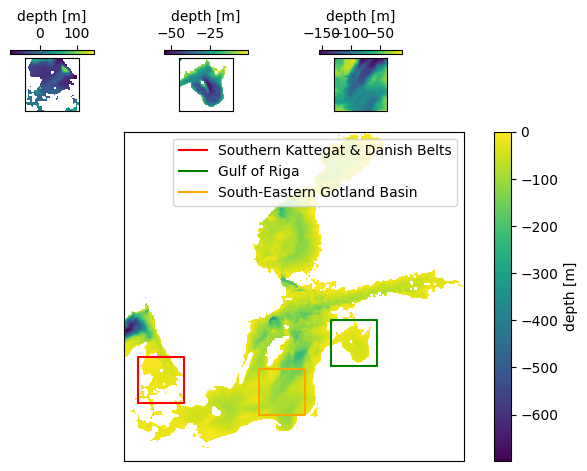

In [ ]:
plt.figure()
ax1 = plt.subplot2grid((20, 16), (4, 0), colspan=16, rowspan=16)
ax2 = plt.subplot2grid((20, 16), (0, 0), colspan=4, rowspan=4)
ax3 = plt.subplot2grid((20, 16), (0, 4), colspan=4, rowspan=4)
ax4 = plt.subplot2grid((20, 16), (0, 8), colspan=4, rowspan=4)


ax1.set_xticks([])
ax2.set_xticks([])
ax3.set_xticks([])
ax4.set_xticks([])

ax1.set_yticks([])
ax2.set_yticks([])
ax3.set_yticks([])
ax4.set_yticks([])



im = ax1.imshow(np.where(landmask_array == 0, topo_array, np.nan), origin='lower')
im2 = ax2.imshow(np.where(landmask_array[200:360, 50:210] == 0, topo_array[50:210,200:360], np.nan), origin='lower')
im3 = ax3.imshow(np.where(landmask_array[330:490, 720:880] == 0, topo_array[330:490, 720:880], np.nan), origin='lower')
im4 = ax4.imshow(np.where(landmask_array[160:320, 470:630] == 0, topo_array[160:320, 470:630], np.nan), origin='lower')
# area of kattegat waters, denmark
coord_dk = [[50,200], [50,360], [210,360], [210,200]]
coord_dk.append(coord_dk[0])
xs_dk, ys_dk = zip(*coord_dk)
# area of golf of riga
coord_rg = [[720,330], [720,490], [880,490], [880,330]]
coord_rg.append(coord_rg[0])
xs_rg, ys_rg = zip(*coord_rg)
# area of bothnian sea
coord_bb = [[470,160], [470,320], [630,320], [630,160]]
coord_bb.append(coord_bb[0])
xs_bb, ys_bb = zip(*coord_bb)

ax1.plot(xs_dk,ys_dk, color='red', label='Southern Kattegat & Danish Belts')
ax1.plot(xs_rg,ys_rg, color='green', label='Gulf of Riga')
ax1.plot(xs_bb,ys_bb, color='orange', label='South-Eastern Gotland Basin')
ax1.legend()



c1 = plt.colorbar(im, ax=ax1,label='depth [m]')
c2 = plt.colorbar(im2, ax=ax2,label='depth [m]', orientation='horizontal', location='top', shrink=0.6)
c3 = plt.colorbar(im3, ax=ax3,label='depth [m]', orientation='horizontal', location='top', shrink=0.6)
c4 = plt.colorbar(im4, ax=ax4,label='depth [m]', orientation='horizontal', location='top', shrink=0.6)
plt.tight_layout()
plt.show()

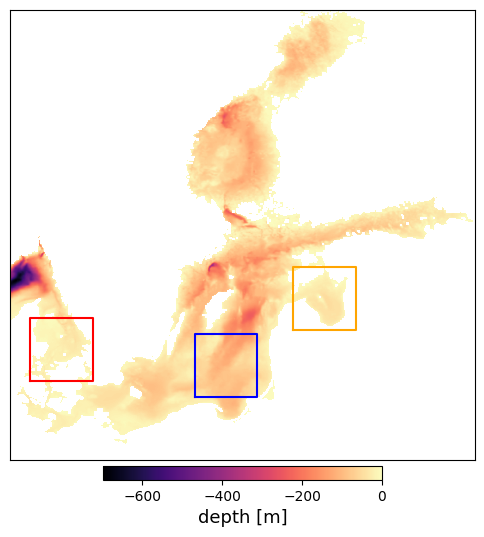

In [ ]:
plt.figure(figsize=(6,8))
plt.imshow(np.where(landmask_array == 0, topo_array, np.nan), origin='lower', cmap='magma')
coord_dk = [[50,200], [50,360], [210,360], [210,200]]
coord_dk.append(coord_dk[0])
xs_dk, ys_dk = zip(*coord_dk)
# area of golf of riga
coord_rg = [[720,330], [720,490], [880,490], [880,330]]
coord_rg.append(coord_rg[0])
xs_rg, ys_rg = zip(*coord_rg)
# area of bothnian sea
coord_bb = [[470,160], [470,320], [630,320], [630,160]]
coord_bb.append(coord_bb[0])
xs_bb, ys_bb = zip(*coord_bb)

plt.plot(xs_dk,ys_dk, color='red', label='Southern Kattegat & Danish Belts')
plt.plot(xs_rg,ys_rg, color='orange', label='Gulf of Riga')
plt.plot(xs_bb,ys_bb, color='blue', label='South-Eastern Gotland Basin')
plt.yticks([])
plt.xticks([])

colorbar = plt.colorbar(location='bottom', shrink=0.6, pad=0.01, )

# Set the font size of the colorbar label
colorbar.set_label('depth [m]', fontsize=13)
plt.show()

<ipython-input-97-6343bed3d0ad>:6: UserWarning: FixedFormatter should only be used together with FixedLocator
  cbar.ax.set_yticklabels(ticklabs, fontsize=12)


[Text(1, -70.0, '−70'),
 Text(1, -60.0, '−60'),
 Text(1, -50.0, '−50'),
 Text(1, -40.0, '−40'),
 Text(1, -30.0, '−30'),
 Text(1, -20.0, '−20'),
 Text(1, -10.0, '−10'),
 Text(1, 0.0, '0')]

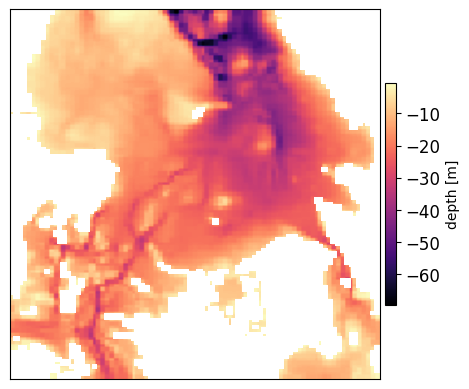

In [ ]:
plt.imshow(np.where(landmask_array[200:360, 50:210] == 0, topo_array[200:360, 50:210], np.nan), origin='lower', cmap='magma')
plt.xticks([])
plt.yticks([])
cbar = plt.colorbar(label='depth [m]', shrink=0.6, pad=0.01)
ticklabs = cbar.ax.get_yticklabels()
cbar.ax.set_yticklabels(ticklabs, fontsize=12)

<ipython-input-98-222d7adcbada>:6: UserWarning: FixedFormatter should only be used together with FixedLocator
  cbar.ax.set_yticklabels(ticklabs, fontsize=12)


[Text(1, -60.0, '−60'),
 Text(1, -50.0, '−50'),
 Text(1, -40.0, '−40'),
 Text(1, -30.0, '−30'),
 Text(1, -20.0, '−20'),
 Text(1, -10.0, '−10'),
 Text(1, 0.0, '0')]

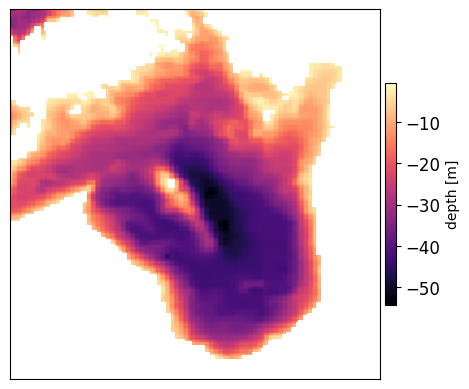

In [ ]:
plt.imshow(np.where(landmask_array[330:490, 720:880] == 0, topo_array[330:490, 720:880], np.nan), origin='lower', cmap='magma')
plt.xticks([])
plt.yticks([])
cbar = plt.colorbar(label='depth [m]', shrink=0.6, pad=0.01)
ticklabs = cbar.ax.get_yticklabels()
cbar.ax.set_yticklabels(ticklabs, fontsize=12)

<ipython-input-99-dbf938c082cc>:6: UserWarning: FixedFormatter should only be used together with FixedLocator
  cbar.ax.set_yticklabels(ticklabs, fontsize=12)


[Text(1, -175.0, '−175'),
 Text(1, -150.0, '−150'),
 Text(1, -125.0, '−125'),
 Text(1, -100.0, '−100'),
 Text(1, -75.0, '−75'),
 Text(1, -50.0, '−50'),
 Text(1, -25.0, '−25'),
 Text(1, 0.0, '0')]

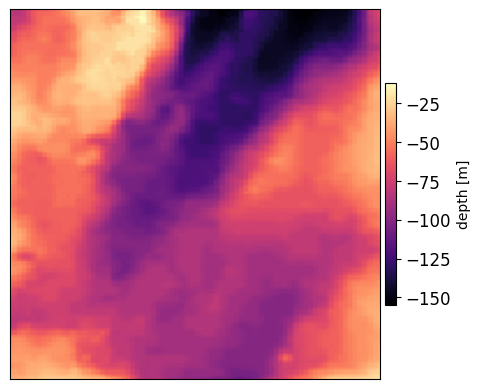

In [ ]:
plt.imshow(np.where(landmask_array[160:320, 470:630] == 0, topo_array[160:320, 470:630], np.nan), origin='lower', cmap='magma')
plt.xticks([])
plt.yticks([])
cbar = plt.colorbar(label='depth [m]', shrink=0.6, pad=0.01)
ticklabs = cbar.ax.get_yticklabels()
cbar.ax.set_yticklabels(ticklabs, fontsize=12)

In [ ]:
riga_range_x  = range(720,880,1)
riga_range_y = range(330,490,1)

kattegat_range_x  = range(50,210,1)
kattegat_range_y = range(200,360,1)

gotland_range_x  = range(470,630,1)
gotland_range_y = range(160,320,1)

In [ ]:
# generate a distance map between sea and coastline
from collections import deque

def distance_map(coastline):
    rows = len(coastline)
    cols = len(coastline[0])

    # Initialize the distance map with large values
    distance = [[float('inf') for _ in range(cols)] for _ in range(rows)]

    # Define the directions to explore the neighbors
    directions = [(0, 1), (0, -1), (1, 0), (-1, 0)]

    # Create a queue for BFS
    queue = deque()

    # Initialize the queue with land pixels
    for i in range(rows):
        for j in range(cols):
            if coastline[i][j] == 1:
                queue.append((i, j))
                distance[i][j] = 0

    # Perform BFS to update the distance map
    while queue:
        x, y = queue.popleft()

        # Explore the neighbors in all four directions
        for dx, dy in directions:
            nx, ny = x + dx, y + dy

            # Check if the neighbor is within the valid range
            if 0 <= nx < rows and 0 <= ny < cols:

                # Check if the neighbor is a sea pixel
                if coastline[nx][ny] == 0 and distance[nx][ny] == float('inf'):
                    distance[nx][ny] = distance[x][y] + 1
                    queue.append((nx, ny))

    return distance

In [ ]:
distances = distance_map(landmask_array)

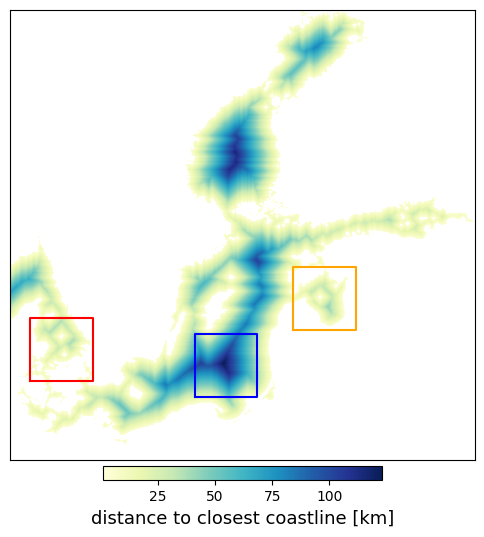

In [ ]:
plt.figure(figsize=(6,8))
plt.imshow(np.where(landmask_array == 0, distances, np.nan), origin='lower', cmap='YlGnBu')
coord_dk = [[50,200], [50,360], [210,360], [210,200]]
coord_dk.append(coord_dk[0])
xs_dk, ys_dk = zip(*coord_dk)
# area of golf of riga
coord_rg = [[720,330], [720,490], [880,490], [880,330]]
coord_rg.append(coord_rg[0])
xs_rg, ys_rg = zip(*coord_rg)
# area of bothnian sea
coord_bb = [[470,160], [470,320], [630,320], [630,160]]
coord_bb.append(coord_bb[0])
xs_bb, ys_bb = zip(*coord_bb)

plt.plot(xs_dk,ys_dk, color='red', label='Southern Kattegat & Danish Belts')
plt.plot(xs_rg,ys_rg, color='orange', label='Gulf of Riga')
plt.plot(xs_bb,ys_bb, color='blue', label='South-Eastern Gotland Basin')
plt.yticks([])
plt.xticks([])
colorbar = plt.colorbar(location='bottom', shrink=0.6, pad=0.01, )

# Set the font size of the colorbar label
colorbar.set_label("distance to closest coastline [km]", fontsize=13)
plt.show()
plt.show()

<ipython-input-113-19724673c772>:6: UserWarning: FixedFormatter should only be used together with FixedLocator
  cbar.ax.set_yticklabels(ticklabs, fontsize=12)


[Text(1, 0.0, '0'),
 Text(1, 10.0, '10'),
 Text(1, 20.0, '20'),
 Text(1, 30.0, '30'),
 Text(1, 40.0, '40')]

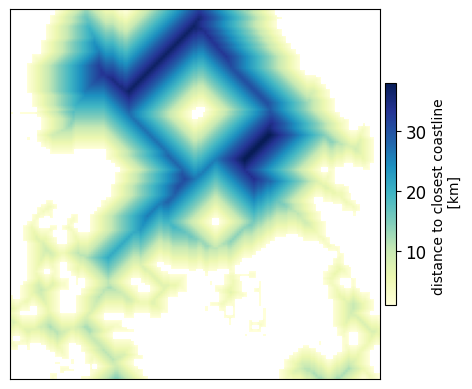

In [ ]:
plt.imshow(np.where(landmask_array[200:360, 50:210] == 0, np.array(distances)[200:360, 50:210], np.nan), origin='lower', cmap='YlGnBu')
plt.xticks([])
plt.yticks([])
cbar = plt.colorbar(label="distance to closest coastline \n [km]", shrink=0.6, pad=0.01)
ticklabs = cbar.ax.get_yticklabels()
cbar.ax.set_yticklabels(ticklabs, fontsize=12)

<ipython-input-114-5255e68bf54b>:6: UserWarning: FixedFormatter should only be used together with FixedLocator
  cbar.ax.set_yticklabels(ticklabs, fontsize=12)


[Text(1, 0.0, '0'),
 Text(1, 10.0, '10'),
 Text(1, 20.0, '20'),
 Text(1, 30.0, '30'),
 Text(1, 40.0, '40'),
 Text(1, 50.0, '50')]

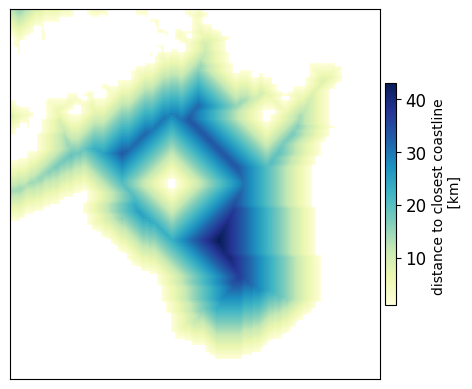

In [ ]:
plt.imshow(np.where(landmask_array[330:490, 720:880] == 0, np.array(distances)[330:490, 720:880], np.nan), origin='lower', cmap='YlGnBu')
plt.xticks([])
plt.yticks([])
cbar = plt.colorbar(label="distance to closest coastline \n [km]", shrink=0.6, pad=0.01)
ticklabs = cbar.ax.get_yticklabels()
cbar.ax.set_yticklabels(ticklabs, fontsize=12)

<ipython-input-116-0a0112e4ba43>:6: UserWarning: FixedFormatter should only be used together with FixedLocator
  cbar.ax.set_yticklabels(ticklabs, fontsize=12)


[Text(1, 0.0, '0'),
 Text(1, 20.0, '20'),
 Text(1, 40.0, '40'),
 Text(1, 60.0, '60'),
 Text(1, 80.0, '80'),
 Text(1, 100.0, '100'),
 Text(1, 120.0, '120'),
 Text(1, 140.0, '140')]

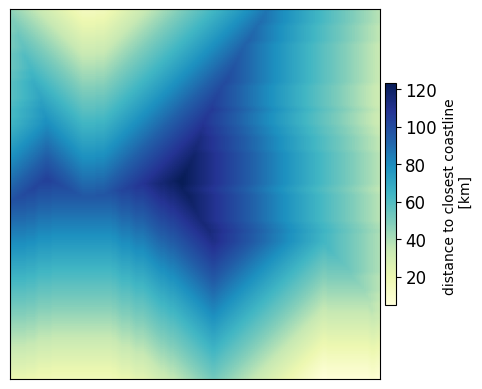

In [ ]:
plt.imshow(np.where(landmask_array[160:320, 470:630] == 0, np.array(distances)[160:320, 470:630], np.nan), origin='lower', cmap='YlGnBu')
plt.xticks([])
plt.yticks([])
cbar = plt.colorbar(label="distance to closest coastline \n [km]", shrink=0.6, pad=0.01)
ticklabs = cbar.ax.get_yticklabels()
cbar.ax.set_yticklabels(ticklabs, fontsize=12)

## Plot to show noisy data

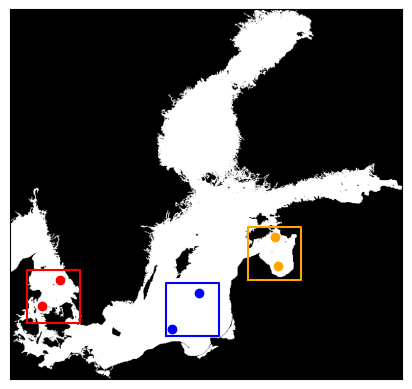

In [ ]:
# area of kattegat waters, denmark
coord_dk = [[50,170], [50,330], [210,330], [210,170]]
coord_dk.append(coord_dk[0])
xs_dk, ys_dk = zip(*coord_dk)
# area of golf of riga
coord_rg = [[720,300], [720,460], [880,460], [880,300]]
coord_rg.append(coord_rg[0])
xs_rg, ys_rg = zip(*coord_rg)
# area of bothnian sea
coord_bb = [[470,130], [470,290], [630,290], [630,130]]
coord_bb.append(coord_bb[0])
xs_bb, ys_bb = zip(*coord_bb)


plt.figure()
plt.imshow(mask_data_resampled.LANDMASK[30:,:], origin='lower', cmap='Greys')
plt.plot(xs_dk,ys_dk, color='red', label='Southern Kattegat & Danish Belts')
plt.plot(xs_rg,ys_rg, color='orange', label='Gulf of Riga')
plt.plot(xs_bb,ys_bb, color='blue', label='South-Eastern Gotland Basin')
plt.scatter([150],[300], marker='o', color='red')
plt.scatter([95],[220], marker='o', color='red')

plt.scatter([800],[430], marker='o', color='orange')
plt.scatter([810],[340], marker='o', color='orange')

plt.scatter([490],[150], marker='o', color='blue')
plt.scatter([570],[260], marker='o', color='blue')
plt.xticks([])
plt.yticks([])
# plt.legend()
plt.show()

<ipython-input-228-355a945e9e65>:2: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cm = plt.cm.get_cmap('viridis')


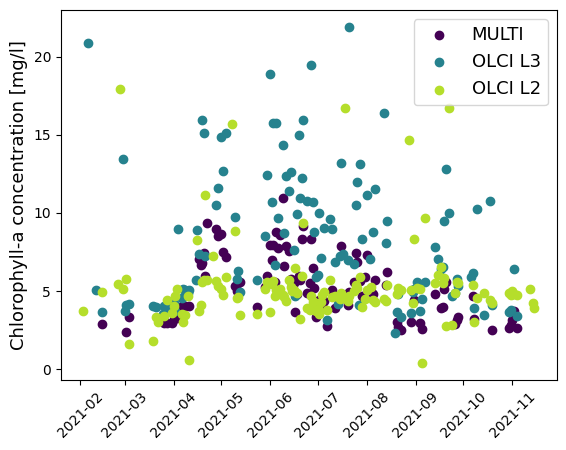

In [ ]:
from matplotlib.colors import ListedColormap
cm = plt.cm.get_cmap('viridis')
my_cmap = cm(np.linspace(0,1,10))

# Create new colormap
my_cmap = ListedColormap(my_cmap)
plt.figure()
plt.scatter(multi_times[8550:8845],chl_array_multi_RIGA[8550:8845,130,80], color=my_cmap(0), label='MULTI')
plt.scatter(multi_times[8550:8845],chl_array_olci_RIGA[1736:2031,130,80], color=my_cmap(4), label='OLCI L3')
plt.scatter(multi_times[8550:8845],10**chl_array_olci_L2_RIGA[30:325,130,80], color=my_cmap(8), label='OLCI L2')
plt.ylabel('Chlorophyll-a concentration [mg/l]', fontsize=13)
plt.xticks(rotation=45)
plt.legend(fontsize=13)

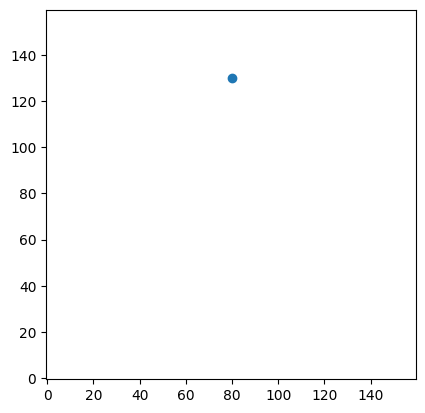

In [ ]:
plt.imshow(chl_array_multi_RIGA[0,:,:], origin='lower')
plt.scatter([80],[130])

## Get the boxcox factor and min/max values for MULTI and OLCI data

In [ ]:
from scipy import stats
y_boxcox_multi_RIGA, lamb_multi_RIGA = stats.boxcox(chl_array_multi_RIGA [~np.isnan(chl_array_multi_RIGA )])
y_boxcox_olci_RIGA, lamb_olci_RIGA = stats.boxcox(chl_array_olci_RIGA [~np.isnan(chl_array_olci_RIGA )])
min_multi_RIGA = np.nanmin(chl_array_multi_RIGA)
max_multi_RIGA = np.nanmax(chl_array_multi_RIGA)
min_olci_RIGA = np.nanmin(chl_array_olci_RIGA)
max_olci_RIGA = np.nanmax(chl_array_olci_RIGA)
cb_min_multi_RIGA = np.nanmin(y_boxcox_multi_RIGA)
cb_max_multi_RIGA = np.nanmax(y_boxcox_multi_RIGA)
cb_min_olci_RIGA = np.nanmin(y_boxcox_olci_RIGA)
cb_max_olci_RIGA = np.nanmax(y_boxcox_olci_RIGA)
print("RIGA")
print(f"lamda multi: {lamb_multi_RIGA}, olci: {lamb_olci_RIGA}")
print(f"min, max multi, min: {min_multi_RIGA}, max: {max_multi_RIGA}")
print(f"min, max olci, min: {min_olci_RIGA}, max: {max_olci_RIGA}")
print(f"cb min, cb max multi, min: {cb_min_multi_RIGA}, max: {cb_max_multi_RIGA}")
print(f"cb min, cb max olci, min: {cb_min_olci_RIGA}, max: {cb_max_olci_RIGA}")
print(f"std: multi:{np.nanstd(chl_array_multi_RIGA)}, olci: {np.nanstd(chl_array_olci_RIGA)}")
print(f"mean: multi:{np.nanmean(chl_array_multi_RIGA)}, olci: {np.nanmean(chl_array_olci_RIGA)}, total: {np.nanmean(np.append(chl_array_olci_RIGA, chl_array_multi_RIGA, axis=0))}")

y_boxcox_multi_KTT, lamb_multi_KTT = stats.boxcox(chl_array_multi_KTT [~np.isnan(chl_array_multi_KTT )])
y_boxcox_olci_KTT, lamb_olci_KTT = stats.boxcox(chl_array_olci_KTT [~np.isnan(chl_array_olci_KTT )])
min_multi_KTT = np.nanmin(chl_array_multi_KTT)
max_multi_KTT = np.nanmax(chl_array_multi_KTT)
min_olci_KTT = np.nanmin(chl_array_olci_KTT)
max_olci_KTT = np.nanmax(chl_array_olci_KTT)
print("KTT")
print(f"lamda multi: {lamb_multi_KTT}, olci: {lamb_olci_KTT}")
print(f"min, max multi, min: {min_multi_KTT}, max: {max_multi_KTT}")
print(f"min, max olci, min: {min_olci_KTT}, max: {max_olci_KTT}")
print(f"std: multi:{np.nanstd(chl_array_multi_KTT)}, olci: {np.nanstd(chl_array_olci_KTT)}")
print(f"mean: multi:{np.nanmean(chl_array_multi_KTT)}, olci: {np.nanmean(chl_array_olci_KTT)}, total: {np.nanmean(np.append(chl_array_olci_KTT, chl_array_multi_KTT, axis=0))}")

y_boxcox_multi_GTL, lamb_multi_GTL = stats.boxcox(chl_array_multi_GTL [~np.isnan(chl_array_multi_GTL )])
y_boxcox_olci_GTL, lamb_olci_GTL = stats.boxcox(chl_array_olci_GTL [~np.isnan(chl_array_olci_GTL )])
min_multi_GTL = np.nanmin(chl_array_multi_GTL)
max_multi_GTL = np.nanmax(chl_array_multi_GTL)
min_olci_GTL = np.nanmin(chl_array_olci_GTL)
max_olci_GTL = np.nanmax(chl_array_olci_GTL)
print("GTL")
print(f"lamda multi: {lamb_multi_GTL}, olci: {lamb_olci_GTL}")
print(f"min, max multi, min: {min_multi_GTL}, max: {max_multi_GTL}")
print(f"min, max olci, min: {min_olci_GTL}, max: {max_olci_GTL}")
print(f"std: multi:{np.nanstd(chl_array_multi_GTL)}, olci: {np.nanstd(chl_array_olci_GTL)}")
print(f"mean: multi:{np.nanmean(chl_array_multi_GTL)}, olci: {np.nanmean(chl_array_olci_GTL)}, total: {np.nanmean(np.append(chl_array_olci_GTL, chl_array_multi_GTL, axis=0))}")


RIGA
lamda multi: -0.2816107171659248, olci: -0.08346259836955258
min, max multi, min: 0.12770438194274902, max: 194.84649658203125
min, max olci, min: 1.000003457069397, max: 171.9263916015625
cb min, cb max multi, min: -2.7884672658092775, max: 2.7464589875132868
cb min, cb max olci, min: 3.4570629225793132e-06, max: 4.184180058992348
std: multi:6.489225525812733, olci: 8.972037193633167
mean: multi:6.573723986344045, olci: 10.442650719350134, total: 7.568163260635679
KTT
lamda multi: -0.015201357272472429, olci: -0.306205311552774
min, max multi, min: 0.1258625090122223, max: 194.71963500976562
min, max olci, min: 0.21534013748168945, max: 154.74884033203125
std: multi:1.6024400563885004, olci: 3.6242687864389542
mean: multi:2.0555040694939817, olci: 3.007736926655651, total: 2.3444939406150946
GTL
lamda multi: 0.11532315917361308, olci: 0.0503123478793444
min, max multi, min: 0.07947453111410141, max: 131.93975830078125
min, max olci, min: 0.16629767417907715, max: 123.605216979980

(array([2.0000000e+01, 9.2000000e+01, 1.4800000e+02, 2.2471000e+04,
        6.8164000e+04, 3.2285700e+05, 7.6383240e+06, 1.1898144e+07,
        4.0914030e+06, 3.1642700e+05]),
 array([-2.78846727, -2.23497464, -1.68148202, -1.12798939, -0.57449676,
        -0.02100414,  0.53248849,  1.08598111,  1.63947374,  2.19296636,
         2.74645899]),
 <BarContainer object of 10 artists>)

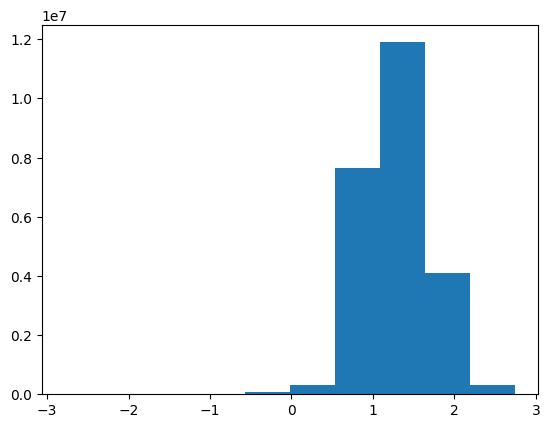

In [ ]:
plt.hist((chl_array_multi_RIGA [~np.isnan(chl_array_multi_RIGA )]**lamb_multi_RIGA-1)/(lamb_multi_RIGA))

(array([  80286.,  167383., 1090833., 1974944., 1826710., 1872014.,
        1118618.,  232846.,   59873.,    3248.]),
 array([3.45706292e-06, 4.18421117e-01, 8.36838777e-01, 1.25525644e+00,
        1.67367410e+00, 2.09209176e+00, 2.51050942e+00, 2.92892708e+00,
        3.34734474e+00, 3.76576240e+00, 4.18418006e+00]),
 <BarContainer object of 10 artists>)

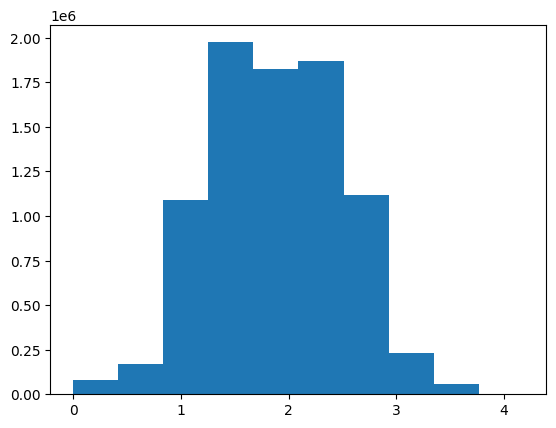

In [ ]:
plt.hist((chl_array_olci_RIGA [~np.isnan(chl_array_olci_RIGA )]**lamb_olci_RIGA-1)/(lamb_olci_RIGA))

(array([2.0000000e+01, 9.2000000e+01, 1.4800000e+02, 2.2471000e+04,
        6.8164000e+04, 3.2285700e+05, 7.6383240e+06, 1.1898144e+07,
        4.0914030e+06, 3.1642700e+05]),
 array([-2.78846727, -2.23497464, -1.68148202, -1.12798939, -0.57449676,
        -0.02100414,  0.53248849,  1.08598111,  1.63947374,  2.19296636,
         2.74645899]),
 <BarContainer object of 10 artists>)

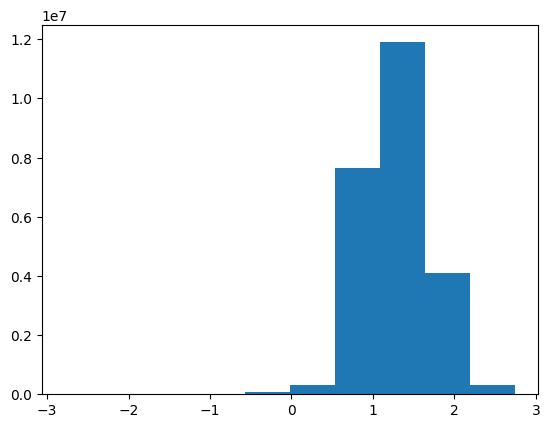

In [ ]:
plt.hist(y_boxcox_multi_RIGA)

(array([  80286.,  167383., 1090833., 1974944., 1826710., 1872014.,
        1118618.,  232846.,   59873.,    3248.]),
 array([3.45706292e-06, 4.18421117e-01, 8.36838777e-01, 1.25525644e+00,
        1.67367410e+00, 2.09209176e+00, 2.51050942e+00, 2.92892708e+00,
        3.34734474e+00, 3.76576240e+00, 4.18418006e+00]),
 <BarContainer object of 10 artists>)

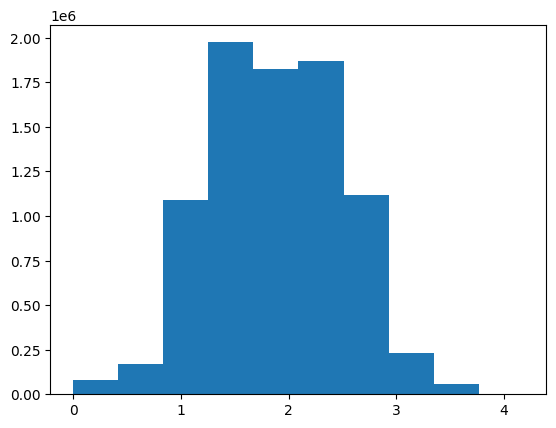

In [ ]:
plt.hist(y_boxcox_olci_RIGA)

## Comparison and Exploration of the three areas

In [ ]:
def nan_helper(y):
    return np.isnan(y), lambda z: z.nonzero()[0]

def generate_plots_1(KTT_vals, RIGA_vals, GTL_vals):
  KTT_mean = np.nanmean(KTT_vals, axis=0)
  RIGA_mean = np.nanmean(RIGA_vals, axis=0)
  GTL_mean = np.nanmean(GTL_vals, axis=0)
  KTT_std = np.nanstd(KTT_vals, axis=0)
  RIGA_std = np.nanstd(RIGA_vals, axis=0)
  GTL_std = np.nanstd(GTL_vals, axis=0)

  fig, axes = plt.subplots(1,3, figsize=(15,5))
  p1 = axes[0].imshow(KTT_mean, origin='lower', vmin=0, vmax=10)
  axes[0].set_title("Southern Kattegat",fontsize=18)
  cbar1 = fig.colorbar(p1, ax=axes[0], shrink=0.79, pad=0.02)
  cbar1.set_label(r'Mean Chl-a [$\frac{mg}{m^3}$]', rotation=90, fontsize=16)
  p2 = axes[1].imshow(RIGA_mean, origin='lower', vmin=0, vmax=30)
  axes[1].set_title("Gulf of Riga",fontsize=18)
  cbar2 = fig.colorbar(p2, ax=axes[1], shrink=0.79, pad=0.02)
  cbar2.set_label(r'Mean Chl-a [$\frac{mg}{m^3}$]', rotation=90, fontsize=16)
  p3 = axes[2].imshow(GTL_mean, origin='lower', vmin=0, vmax=5)
  axes[2].set_title("Gotland Basin",fontsize=18)
  cbar3 = fig.colorbar(p3, ax=axes[2], shrink=0.79, pad=0.02)
  cbar3.set_label(r'Mean Chl-a [$\frac{mg}{m^3}$]', rotation=90, fontsize=16)
  fig.suptitle('Mean values of the three subareas', fontsize=20)
  plt.tight_layout()
  plt.show()

  fig, axes = plt.subplots(1,3, figsize=(15,5))
  p1 = axes[0].imshow(KTT_std, origin='lower', vmin=0, vmax=10)
  axes[0].set_title("Southern Kattegat",fontsize=18)
  cbar1 = fig.colorbar(p1, ax=axes[0], shrink=0.79, pad=0.02)
  cbar1.set_label(r'Std Chl-a [$\frac{mg}{m^3}$]', rotation=90, fontsize=16)
  p2 = axes[1].imshow(RIGA_std, origin='lower', vmin=0, vmax=30)
  axes[1].set_title("Gulf of Riga",fontsize=18)
  cbar2 = fig.colorbar(p2, ax=axes[1], shrink=0.79, pad=0.02)
  cbar2.set_label(r'Std Chl-a [$\frac{mg}{m^3}$]', rotation=90, fontsize=16)
  p3 = axes[2].imshow(GTL_std, origin='lower', vmin=0, vmax=5)
  axes[2].set_title("Gotland Basin",fontsize=18)
  cbar3 = fig.colorbar(p3, ax=axes[2], shrink=0.79, pad=0.02)
  cbar3.set_label(r'Std Chl-a [$\frac{mg}{m^3}$]', rotation=90, fontsize=16)
  fig.suptitle('Standard deviation of the three subareas', fontsize=20)
  plt.tight_layout()
  plt.show()

  KTT_spatmean = np.nanmean(KTT_vals, axis= (1,2))
  KTT_spatstd = np.nanstd(KTT_vals, axis= (1,2))
  RIGA_spatmean = np.nanmean(RIGA_vals, axis= (1,2))
  RIGA_spatstd = np.nanstd(RIGA_vals, axis= (1,2))
  GTL_spatmean = np.nanmean(GTL_vals, axis= (1,2))
  GTL_spatstd = np.nanstd(GTL_vals, axis= (1,2))

  assert KTT_spatmean.shape == RIGA_spatmean.shape and KTT_spatmean.shape == GTL_spatmean.shape

  x = KTT_spatmean.shape[0]

  plt.figure()
  plt.plot(range(x), KTT_spatmean, color='red', label='Southern Kattegat')
  plt.fill_between(range(x), KTT_spatmean+KTT_spatstd, KTT_spatmean-KTT_spatstd, alpha = 0.2, color = 'red')
  plt.plot(range(x), GTL_spatmean, color='orange', label='South Eastern Gotland Basin')
  plt.fill_between(range(x), GTL_spatmean+GTL_spatstd, GTL_spatmean-GTL_spatstd, alpha = 0.2, color = 'orange')
  plt.plot(range(x), RIGA_spatmean, color='green', label='Gulf of Riga')
  plt.fill_between(range(x), RIGA_spatmean+RIGA_spatstd, RIGA_spatmean-RIGA_spatstd, alpha = 0.2, color = 'green')
  plt.legend()
  plt.title('Time series of daily mean and standard deviation of the three subareas')
  plt.show()


In [ ]:
def generate_plots_2(KTT_vals, RIGA_vals, GTL_vals, times):
  KTT_spatmean = np.nanmean(KTT_vals, axis= (1,2))
  KTT_spatstd = np.nanstd(KTT_vals, axis= (1,2))
  RIGA_spatmean = np.nanmean(RIGA_vals, axis= (1,2))
  RIGA_spatstd = np.nanstd(RIGA_vals, axis= (1,2))
  GTL_spatmean = np.nanmean(GTL_vals, axis= (1,2))
  GTL_spatstd = np.nanstd(GTL_vals, axis= (1,2))

  assert KTT_spatmean.shape == RIGA_spatmean.shape and KTT_spatmean.shape == GTL_spatmean.shape

  x = KTT_spatmean.shape[0]

  plt.figure()
  plt.plot(times, KTT_spatmean, color='red', label='Southern Kattegat')
  plt.fill_between(times, KTT_spatmean+KTT_spatstd, KTT_spatmean-KTT_spatstd, alpha = 0.2, color = 'red')
  plt.plot(times, GTL_spatmean, color='orange', label='South Eastern Gotland Basin')
  plt.fill_between(times, GTL_spatmean+GTL_spatstd, GTL_spatmean-GTL_spatstd, alpha = 0.2, color = 'orange')
  plt.plot(times, RIGA_spatmean, color='green', label='Gulf of Riga')
  plt.fill_between(times, RIGA_spatmean+RIGA_spatstd, RIGA_spatmean-RIGA_spatstd, alpha = 0.2, color = 'green')
  plt.legend()
  plt.xticks(rotation = 45)
  plt.title('Time series of daily mean and standard deviation of the three subareas')
  plt.show()

  nans_KTT, x_KTT= nan_helper(KTT_spatmean)
  KTT_spatmean[nans_KTT]= np.interp(x_KTT(nans_KTT), x_KTT(~nans_KTT), KTT_spatmean[~nans_KTT])

  nans_RIGA, x_RIGA= nan_helper(RIGA_spatmean)
  RIGA_spatmean[nans_RIGA]= np.interp(x_RIGA(nans_RIGA), x_RIGA(~nans_RIGA), RIGA_spatmean[~nans_RIGA])

  nans_GTL, x_GTL= nan_helper(GTL_spatmean)
  GTL_spatmean[nans_GTL]= np.interp(x_GTL(nans_GTL), x_GTL(~nans_GTL), GTL_spatmean[~nans_GTL])

  # Calculate rolling mean with a window size of 3
  window = np.ones(10) / 10.0
  rolling_mean_KTT = np.convolve(KTT_spatmean, window, mode='same')
  rolling_mean_RIGA = np.convolve(RIGA_spatmean, window, mode='same')
  rolling_mean_GTL = np.convolve(GTL_spatmean, window, mode='same')

  plt.figure(figsize=(10,5))
  plt.plot(times, rolling_mean_KTT, color='red', label='Southern Kattegat')
  plt.plot(times, rolling_mean_GTL, color='orange', label='South Eastern Gotland Basin')
  plt.plot(times, rolling_mean_RIGA, color='green', label='Gulf of Riga')
  plt.legend()
  plt.xticks(rotation = 45)
  plt.title('Time series of interpolated daily mean of the three subareas')
  plt.show()

def generate_plots_4(olci_vals_L3, multi_vals, i):
  #MULTI
  #%% count the number of available pixels in time dimension (0) and shows as percentages in image
  av_pixel_perc_multi = np.sum(~np.isnan(multi_vals), axis=(0))/multi_vals.shape[0] * 100
  max_pixel_perc_multi = np.nanmax(multi_vals, axis=(0))

  # show histogram of available pixels
  hist_data_multi = multi_vals[~np.isnan(multi_vals)].flatten()

  #OLCI
  #%% count the number of available pixels in time dimension (0) and shows as percentages in image
  av_pixel_perc_olci = np.sum(~np.isnan(olci_vals_L3), axis=(0))/olci_vals_L3.shape[0] * 100
  max_pixel_perc_olci = np.nanmax(olci_vals_L3, axis=(0))

  # show histogram of available pixels
  hist_data_olci = olci_vals_L3[~np.isnan(olci_vals_L3)].flatten()

  ax[0,i].set_xticks([])
  ax[0,i].set_yticks([])
  im1 = ax[0,i].imshow(av_pixel_perc_multi, cmap='viridis', origin="lower", vmin=0, vmax=40)


  ax[1,i].set_xticks([])
  ax[1,i].set_yticks([])
  im2 = ax[1,i].imshow(av_pixel_perc_olci, cmap='viridis', origin="lower", vmin=0, vmax=40)

  return im1,im2


def generate_plots_5(olci_vals_L3, multi_vals, i, cmap):
  #MULTI
  #%% count the number of available pixels in time dimension (0) and shows as percentages in image
  av_pixel_perc_multi = np.sum(~np.isnan(multi_vals), axis=(0))/multi_vals.shape[0] * 100
  max_pixel_perc_multi = np.nanmax(multi_vals, axis=(0))

  # show histogram of available pixels
  hist_data_multi = multi_vals[~np.isnan(multi_vals)].flatten()

  #OLCI
  #%% count the number of available pixels in time dimension (0) and shows as percentages in image
  av_pixel_perc_olci = np.sum(~np.isnan(olci_vals_L3), axis=(0))/olci_vals_L3.shape[0] * 100
  max_pixel_perc_olci = np.nanmax(olci_vals_L3, axis=(0))

  # show histogram of available pixels
  hist_data_olci = olci_vals_L3[~np.isnan(olci_vals_L3)].flatten()

  ax[i].hist(hist_data_multi.flatten(), bins=50, color=cmap(0), alpha=0.8, label='MULTI',)
  #ax0].set_yticks([0, 5e6, 1e6, 1.5e6, 2e6, 2.5e6])
  ax[i].set_yscale('log')
  ax[i].set_xlim([0,200])
  ax[i].grid(linestyle='-', linewidth=0.2)

  ax[i].hist(hist_data_olci.flatten(), bins=50, alpha=0.8, label='OLCI', #color='turquoise', ec="darkblue"
               color=cmap(5))

  multi_perc = np.nanmean(np.where(av_pixel_perc_multi ==0, np.nan, av_pixel_perc_multi))
  olci_perc = np.nanmean(np.where(av_pixel_perc_olci ==0, np.nan, av_pixel_perc_olci))
  print(f"Percentage Multi: {multi_perc}, Olci: {olci_perc}")
  #return im1,im2


#### Multi

In [ ]:
KTT_vals = chl_array_multi_KTT
RIGA_vals = chl_array_multi_RIGA
GTL_vals = chl_array_multi_GTL
print(multi_times[4180:4420])

DatetimeIndex(['2009-02-13', '2009-02-14', '2009-02-15', '2009-02-16',
               '2009-02-17', '2009-02-18', '2009-02-19', '2009-02-20',
               '2009-02-21', '2009-02-22',
               ...
               '2009-10-01', '2009-10-02', '2009-10-03', '2009-10-04',
               '2009-10-05', '2009-10-06', '2009-10-07', '2009-10-08',
               '2009-10-09', '2009-10-10'],
              dtype='datetime64[ns]', length=240, freq='D')


In [ ]:
print(multi_times[7089:7384])

DatetimeIndex(['2017-01-31', '2017-02-01', '2017-02-02', '2017-02-03',
               '2017-02-04', '2017-02-05', '2017-02-06', '2017-02-07',
               '2017-02-08', '2017-02-09',
               ...
               '2017-11-12', '2017-11-13', '2017-11-14', '2017-11-15',
               '2017-11-16', '2017-11-17', '2017-11-18', '2017-11-19',
               '2017-11-20', '2017-11-21'],
              dtype='datetime64[ns]', length=295, freq='D')


<ipython-input-251-011c5966d310>:5: RuntimeWarning: Mean of empty slice
  KTT_mean = np.nanmean(KTT_vals, axis=0)
<ipython-input-251-011c5966d310>:6: RuntimeWarning: Mean of empty slice
  RIGA_mean = np.nanmean(RIGA_vals, axis=0)


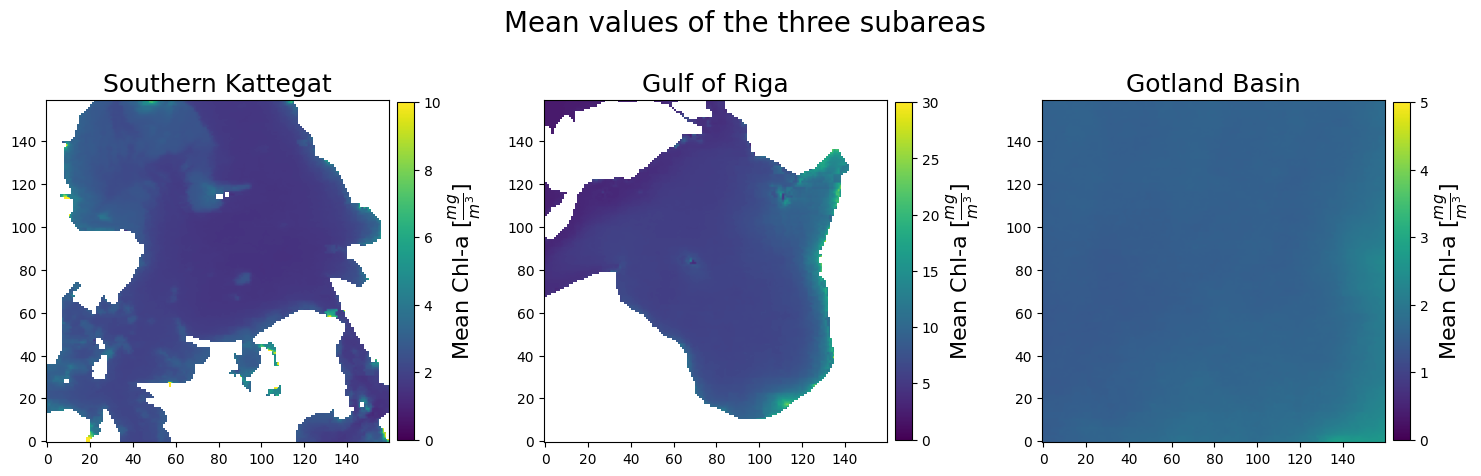

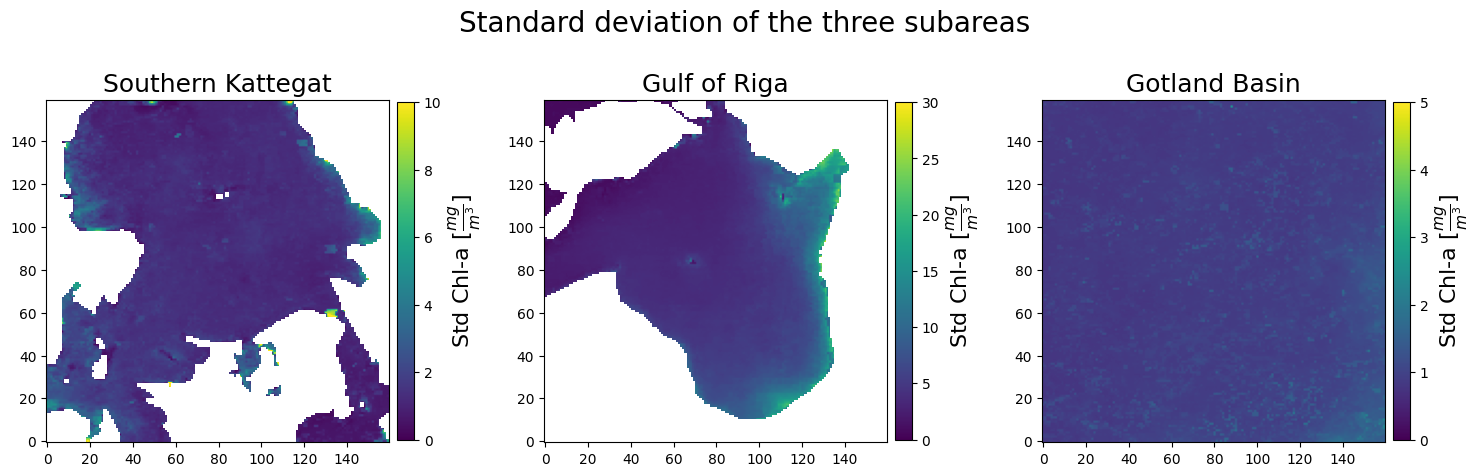

<ipython-input-251-011c5966d310>:46: RuntimeWarning: Mean of empty slice
  KTT_spatmean = np.nanmean(KTT_vals, axis= (1,2))
<ipython-input-251-011c5966d310>:48: RuntimeWarning: Mean of empty slice
  RIGA_spatmean = np.nanmean(RIGA_vals, axis= (1,2))
<ipython-input-251-011c5966d310>:50: RuntimeWarning: Mean of empty slice
  GTL_spatmean = np.nanmean(GTL_vals, axis= (1,2))


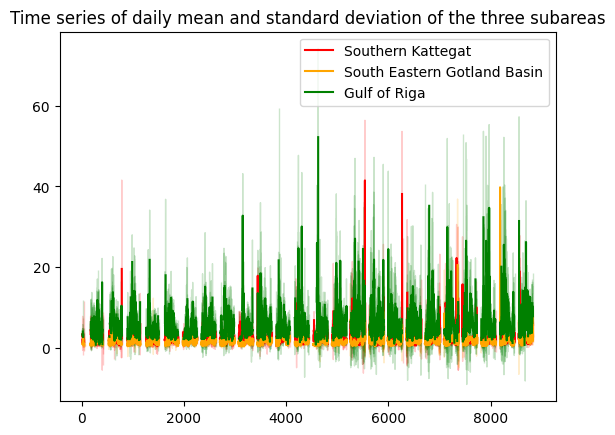

In [ ]:
generate_plots_1(KTT_vals, RIGA_vals, GTL_vals)

<ipython-input-15-98ff6f6b9aa3>:2: RuntimeWarning: Mean of empty slice
  KTT_spatmean = np.nanmean(KTT_vals, axis= (1,2))
<ipython-input-15-98ff6f6b9aa3>:4: RuntimeWarning: Mean of empty slice
  RIGA_spatmean = np.nanmean(RIGA_vals, axis= (1,2))
<ipython-input-15-98ff6f6b9aa3>:6: RuntimeWarning: Mean of empty slice
  GTL_spatmean = np.nanmean(GTL_vals, axis= (1,2))


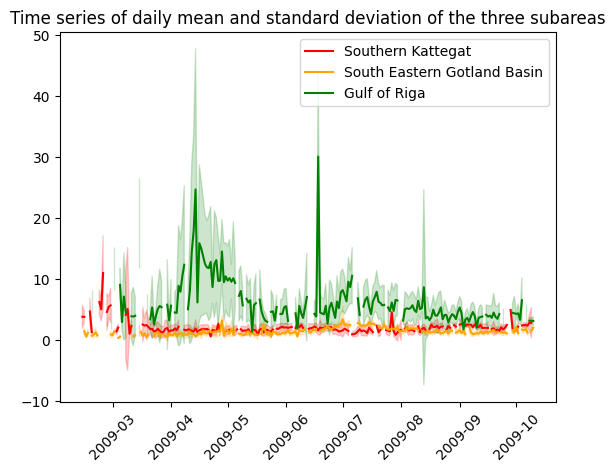

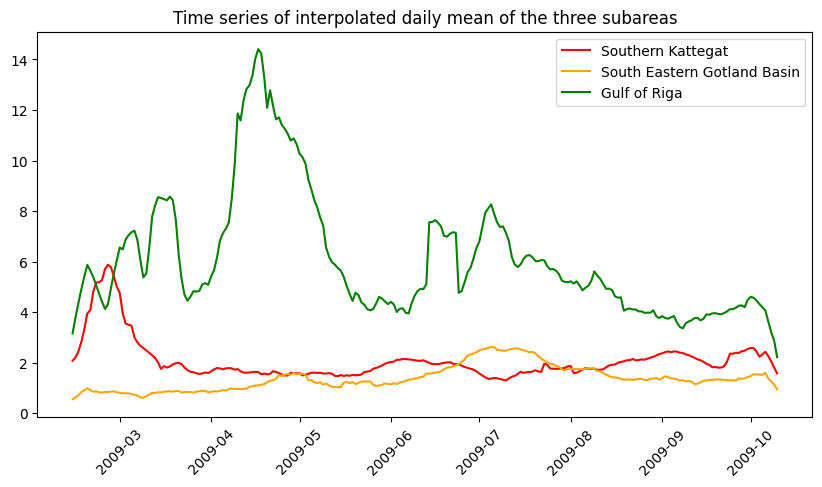

In [ ]:
generate_plots_2(KTT_vals[4180:4420], RIGA_vals[4180:4420], GTL_vals[4180:4420], multi_times[4180:4420])

<ipython-input-15-98ff6f6b9aa3>:2: RuntimeWarning: Mean of empty slice
  KTT_spatmean = np.nanmean(KTT_vals, axis= (1,2))
<ipython-input-15-98ff6f6b9aa3>:4: RuntimeWarning: Mean of empty slice
  RIGA_spatmean = np.nanmean(RIGA_vals, axis= (1,2))
<ipython-input-15-98ff6f6b9aa3>:6: RuntimeWarning: Mean of empty slice
  GTL_spatmean = np.nanmean(GTL_vals, axis= (1,2))


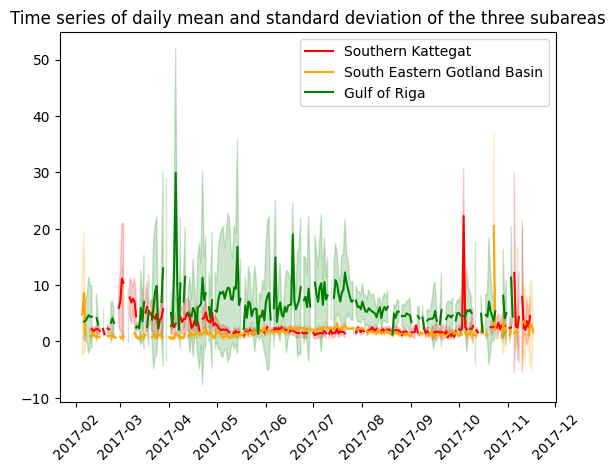

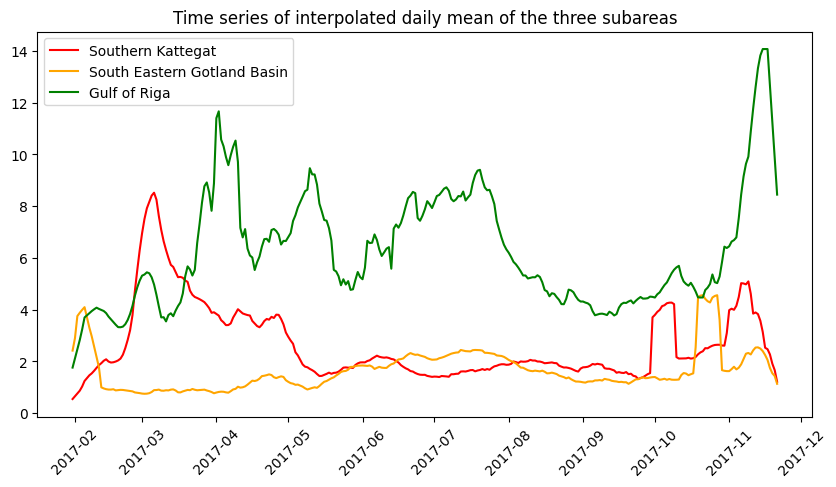

In [ ]:
generate_plots_2(KTT_vals[7089:7384], RIGA_vals[7089:7384], GTL_vals[7089:7384], multi_times[7089:7384])

## OLCI L3

In [ ]:
print(multi_times[8520:8885])

DatetimeIndex(['2021-01-01', '2021-01-02', '2021-01-03', '2021-01-04',
               '2021-01-05', '2021-01-06', '2021-01-07', '2021-01-08',
               '2021-01-09', '2021-01-10',
               ...
               '2021-12-22', '2021-12-23', '2021-12-24', '2021-12-25',
               '2021-12-26', '2021-12-27', '2021-12-28', '2021-12-29',
               '2021-12-30', '2021-12-31'],
              dtype='datetime64[ns]', length=365, freq='D')


<ipython-input-251-011c5966d310>:5: RuntimeWarning: Mean of empty slice
  KTT_mean = np.nanmean(KTT_vals, axis=0)
<ipython-input-251-011c5966d310>:6: RuntimeWarning: Mean of empty slice
  RIGA_mean = np.nanmean(RIGA_vals, axis=0)


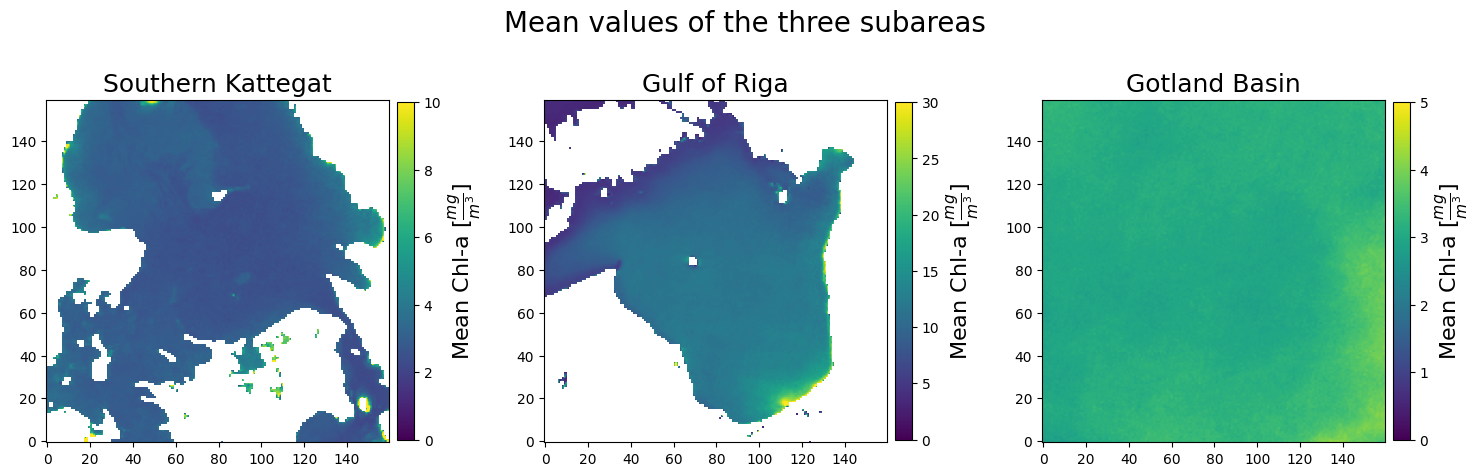

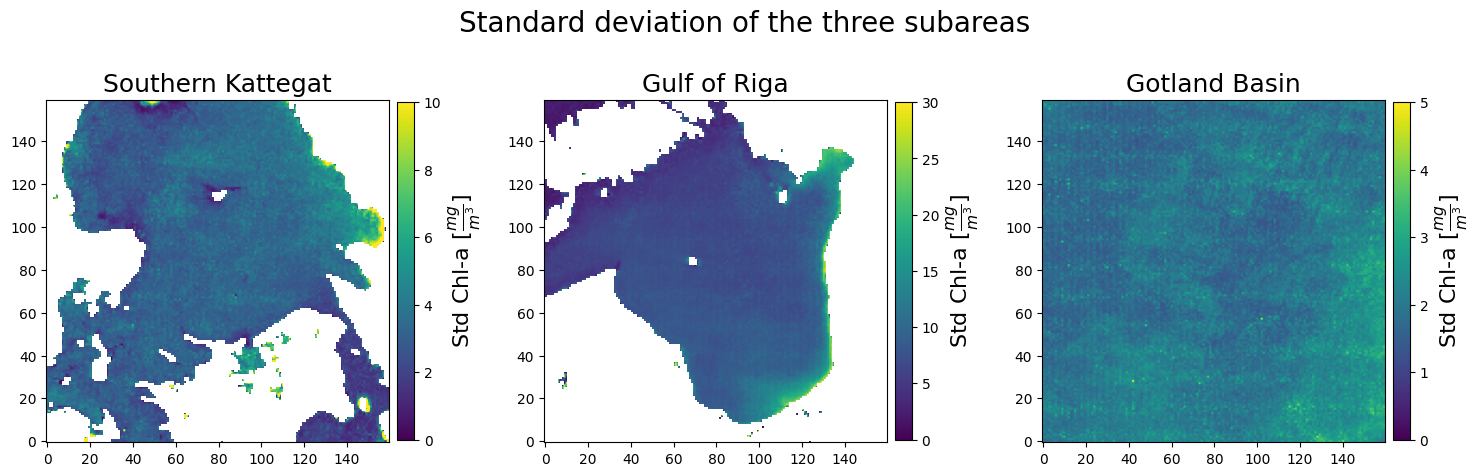

<ipython-input-251-011c5966d310>:46: RuntimeWarning: Mean of empty slice
  KTT_spatmean = np.nanmean(KTT_vals, axis= (1,2))
<ipython-input-251-011c5966d310>:48: RuntimeWarning: Mean of empty slice
  RIGA_spatmean = np.nanmean(RIGA_vals, axis= (1,2))
<ipython-input-251-011c5966d310>:50: RuntimeWarning: Mean of empty slice
  GTL_spatmean = np.nanmean(GTL_vals, axis= (1,2))


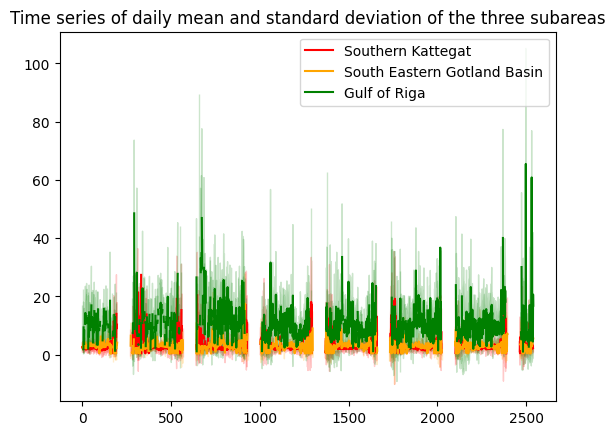

In [ ]:
KTT_vals = chl_array_olci_KTT
RIGA_vals = chl_array_olci_RIGA
GTL_vals = chl_array_olci_GTL
generate_plots_1(KTT_vals, RIGA_vals, GTL_vals)

<ipython-input-15-98ff6f6b9aa3>:2: RuntimeWarning: Mean of empty slice
  KTT_spatmean = np.nanmean(KTT_vals, axis= (1,2))
<ipython-input-15-98ff6f6b9aa3>:4: RuntimeWarning: Mean of empty slice
  RIGA_spatmean = np.nanmean(RIGA_vals, axis= (1,2))
<ipython-input-15-98ff6f6b9aa3>:6: RuntimeWarning: Mean of empty slice
  GTL_spatmean = np.nanmean(GTL_vals, axis= (1,2))


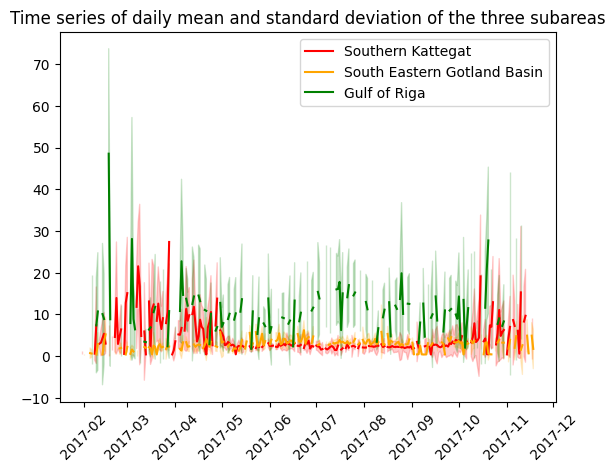

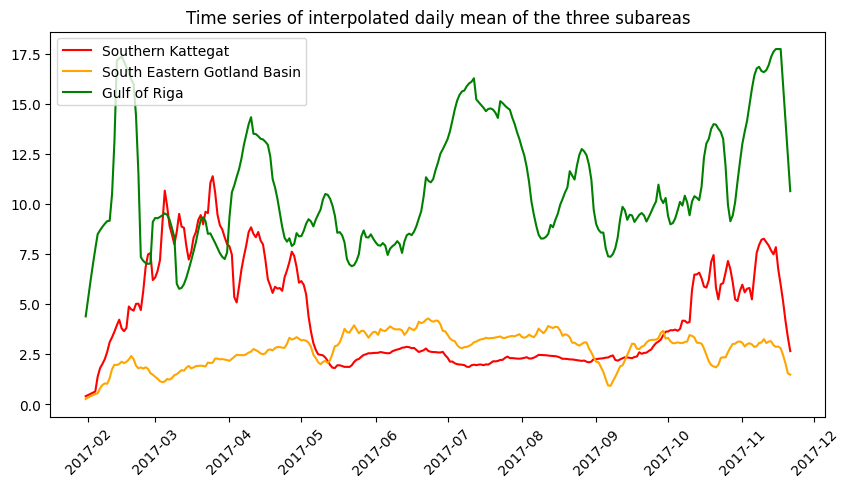

In [ ]:
generate_plots_2(KTT_vals[275:570], RIGA_vals[275:570], GTL_vals[275:570], olci_times[275:570])

<ipython-input-15-98ff6f6b9aa3>:2: RuntimeWarning: Mean of empty slice
  KTT_spatmean = np.nanmean(KTT_vals, axis= (1,2))
<ipython-input-15-98ff6f6b9aa3>:4: RuntimeWarning: Mean of empty slice
  RIGA_spatmean = np.nanmean(RIGA_vals, axis= (1,2))
<ipython-input-15-98ff6f6b9aa3>:6: RuntimeWarning: Mean of empty slice
  GTL_spatmean = np.nanmean(GTL_vals, axis= (1,2))


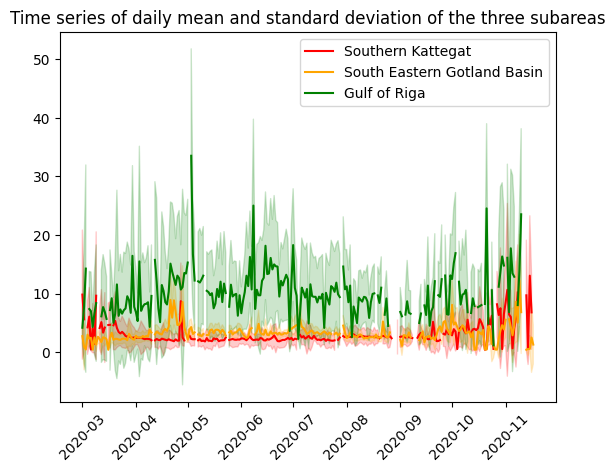

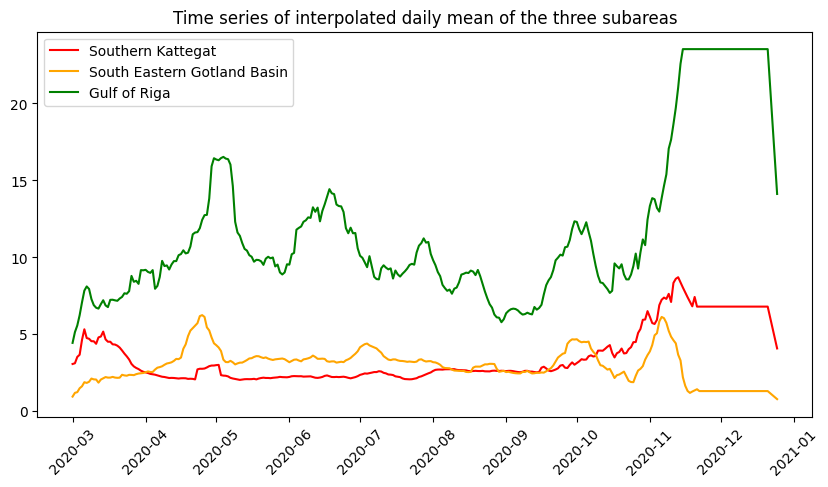

In [ ]:
generate_plots_2(KTT_vals[1400:1700], RIGA_vals[1400:1700], GTL_vals[1400:1700], olci_times[1400:1700])

## OLCI L2

<ipython-input-14-8ed947a5085c>:5: RuntimeWarning: Mean of empty slice
  KTT_mean = np.nanmean(KTT_vals, axis=0)
<ipython-input-14-8ed947a5085c>:6: RuntimeWarning: Mean of empty slice
  RIGA_mean = np.nanmean(RIGA_vals, axis=0)


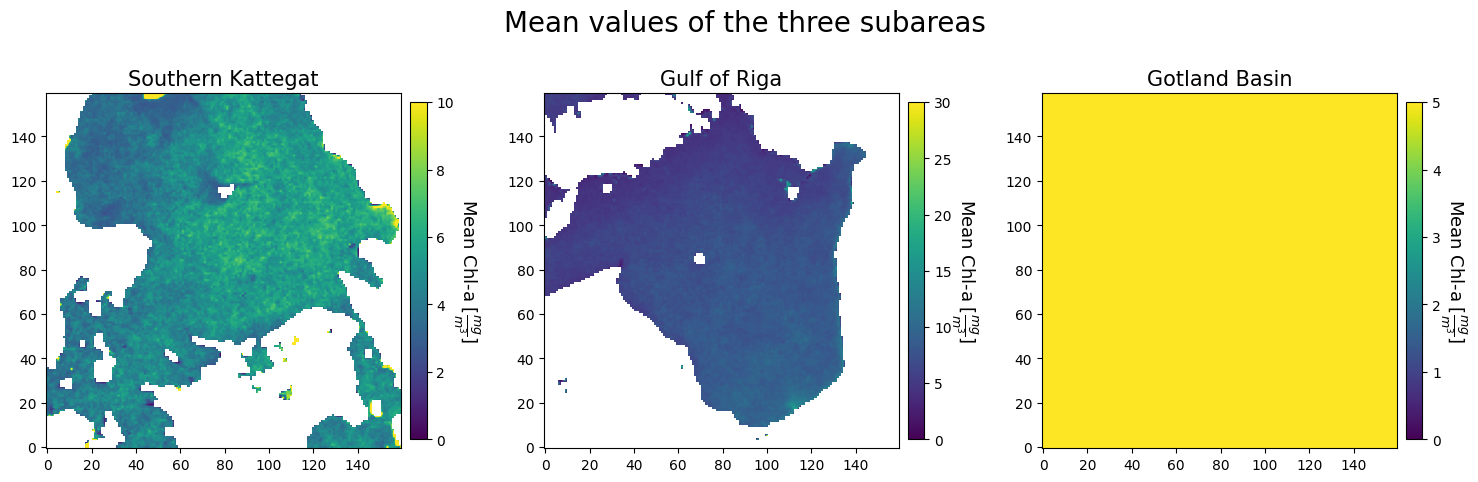

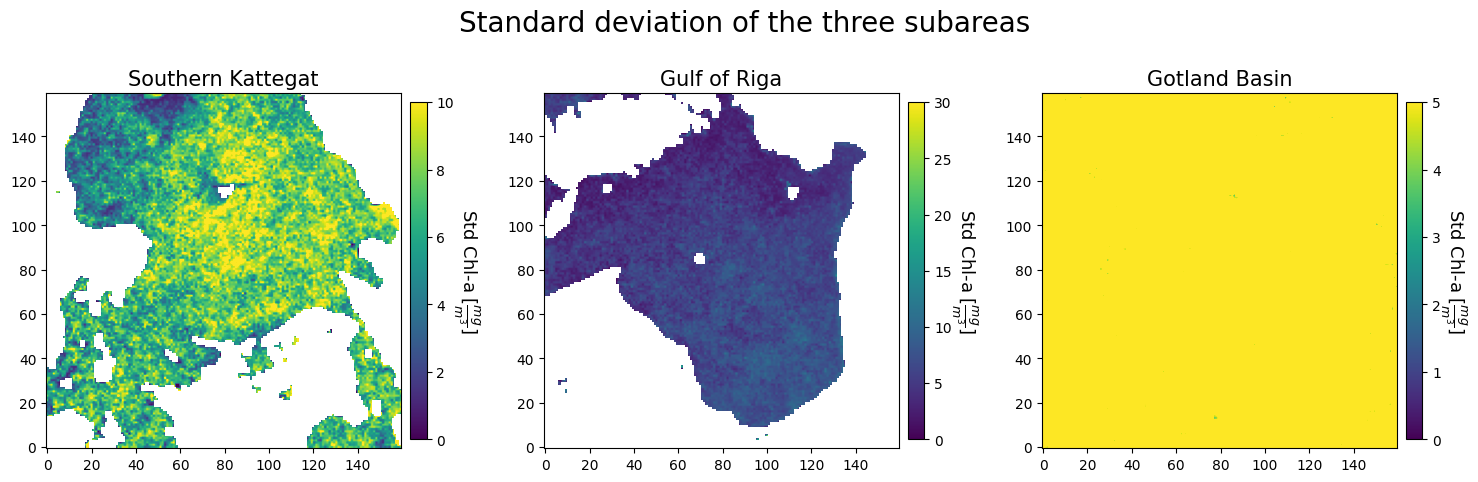

<ipython-input-14-8ed947a5085c>:46: RuntimeWarning: Mean of empty slice
  KTT_spatmean = np.nanmean(KTT_vals, axis= (1,2))
<ipython-input-14-8ed947a5085c>:48: RuntimeWarning: Mean of empty slice
  RIGA_spatmean = np.nanmean(RIGA_vals, axis= (1,2))
<ipython-input-14-8ed947a5085c>:50: RuntimeWarning: Mean of empty slice
  GTL_spatmean = np.nanmean(GTL_vals, axis= (1,2))


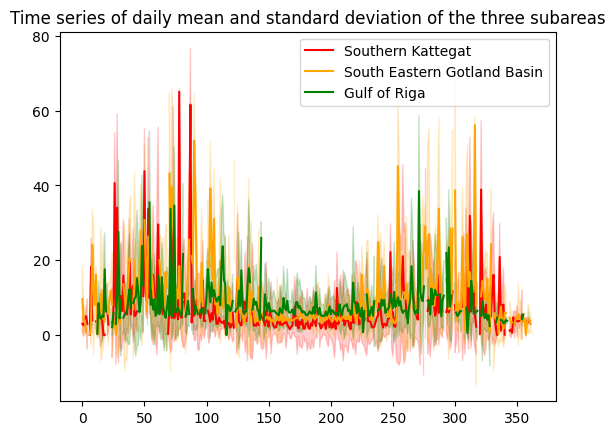

In [ ]:
KTT_vals = 10**chl_array_olci_L2_KTT
RIGA_vals = 10**chl_array_olci_L2_RIGA
GTL_vals = 10**chl_array_olci_L2_GTL
generate_plots_1(KTT_vals, RIGA_vals, GTL_vals)

<ipython-input-15-98ff6f6b9aa3>:2: RuntimeWarning: Mean of empty slice
  KTT_spatmean = np.nanmean(KTT_vals, axis= (1,2))
<ipython-input-15-98ff6f6b9aa3>:4: RuntimeWarning: Mean of empty slice
  RIGA_spatmean = np.nanmean(RIGA_vals, axis= (1,2))
<ipython-input-15-98ff6f6b9aa3>:6: RuntimeWarning: Mean of empty slice
  GTL_spatmean = np.nanmean(GTL_vals, axis= (1,2))


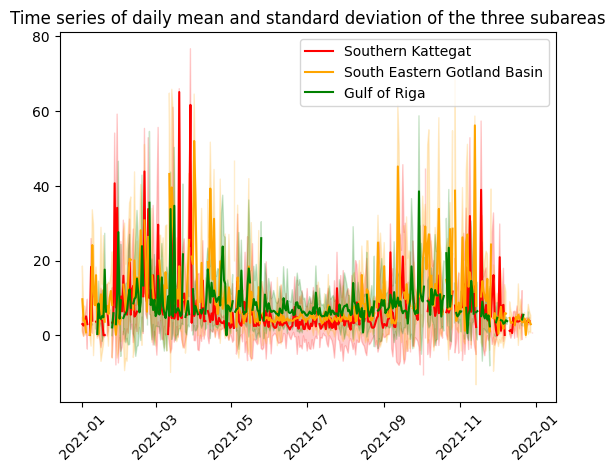

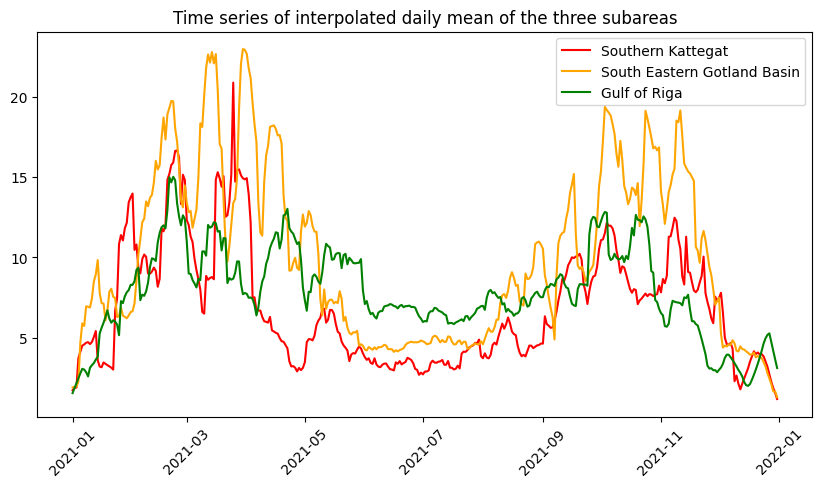

In [ ]:
generate_plots_2(KTT_vals, RIGA_vals, GTL_vals, olci_L2_times)

<ipython-input-231-951535297acc>:2: RuntimeWarning: Mean of empty slice
  KTT_spatmean = np.nanmean(KTT_vals, axis= (1,2))
/usr/local/lib/python3.10/dist-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
<ipython-input-231-951535297acc>:4: RuntimeWarning: Mean of empty slice
  RIGA_spatmean = np.nanmean(RIGA_vals, axis= (1,2))
<ipython-input-231-951535297acc>:6: RuntimeWarning: Mean of empty slice
  GTL_spatmean = np.nanmean(GTL_vals, axis= (1,2))


<Figure size 1400x500 with 0 Axes>

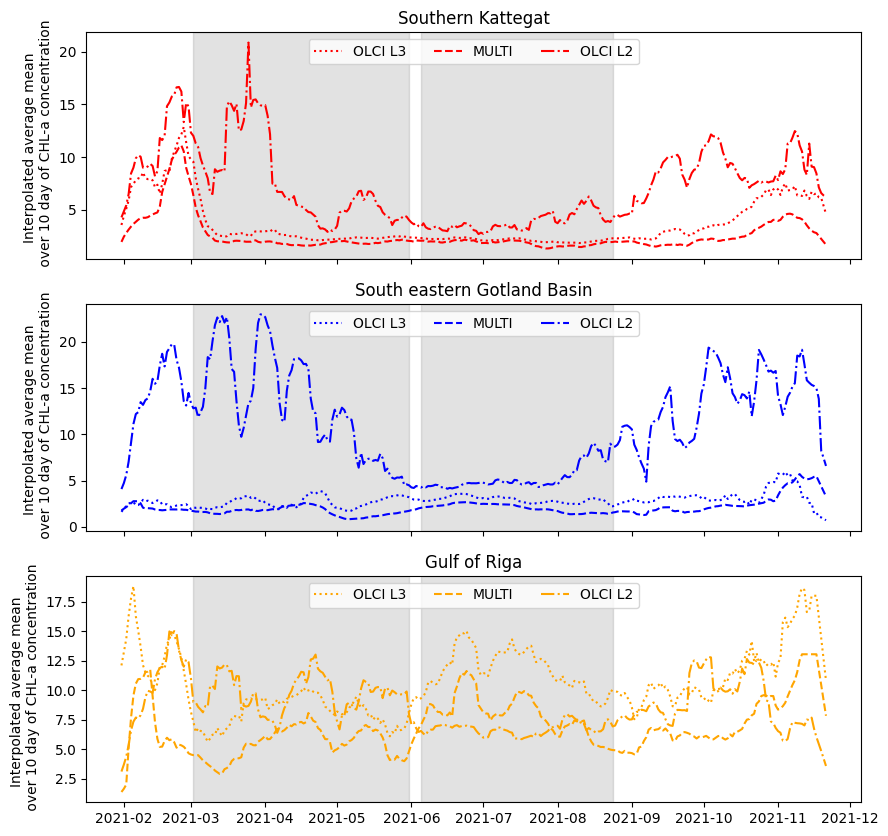

In [ ]:
def generate_plots_3(KTT_vals, RIGA_vals, GTL_vals, times, dataset):
  KTT_spatmean = np.nanmean(KTT_vals, axis= (1,2))
  KTT_spatstd = np.nanstd(KTT_vals, axis= (1,2))
  RIGA_spatmean = np.nanmean(RIGA_vals, axis= (1,2))
  RIGA_spatstd = np.nanstd(RIGA_vals, axis= (1,2))
  GTL_spatmean = np.nanmean(GTL_vals, axis= (1,2))
  GTL_spatstd = np.nanstd(GTL_vals, axis= (1,2))

  assert KTT_spatmean.shape == RIGA_spatmean.shape and KTT_spatmean.shape == GTL_spatmean.shape

  x = KTT_spatmean.shape[0]

  nans_KTT, x_KTT= nan_helper(KTT_spatmean)
  KTT_spatmean[nans_KTT]= np.interp(x_KTT(nans_KTT), x_KTT(~nans_KTT), KTT_spatmean[~nans_KTT])

  nans_RIGA, x_RIGA= nan_helper(RIGA_spatmean)
  RIGA_spatmean[nans_RIGA]= np.interp(x_RIGA(nans_RIGA), x_RIGA(~nans_RIGA), RIGA_spatmean[~nans_RIGA])

  nans_GTL, x_GTL= nan_helper(GTL_spatmean)
  GTL_spatmean[nans_GTL]= np.interp(x_GTL(nans_GTL), x_GTL(~nans_GTL), GTL_spatmean[~nans_GTL])

  # Calculate rolling mean with a window size of 3
  window = np.ones(10) / 10.0
  rolling_mean_KTT = np.convolve(KTT_spatmean, window, mode='same')
  rolling_mean_RIGA = np.convolve(RIGA_spatmean, window, mode='same')
  rolling_mean_GTL = np.convolve(GTL_spatmean, window, mode='same')

  if dataset == "MULTI":
    linestyle='dashed'
  elif dataset == "OLCI L3":
    linestyle='dotted'
  elif dataset == "OLCI L2":
    linestyle='dashdot'

  axes[0].plot(times, rolling_mean_KTT, color='red', linestyle=linestyle, label=f'{dataset}')
  axes[1].plot(times, rolling_mean_GTL, color='blue', linestyle=linestyle, label=f'{dataset}')
  axes[2].plot(times, rolling_mean_RIGA, color='orange', linestyle=linestyle, label=f'{dataset}')
  axes[0].axvspan(times[30], times[120], alpha=0.08, color='grey')
  axes[1].axvspan(times[30], times[120], alpha=0.08, color='grey')
  axes[2].axvspan(times[30], times[120], alpha=0.08, color='grey')

  axes[0].axvspan(times[125], times[205], alpha=0.08, color='grey')
  axes[1].axvspan(times[125], times[205], alpha=0.08, color='grey')
  axes[2].axvspan(times[125], times[205], alpha=0.08, color='grey')


plt.figure(figsize=(14,5))
fig, axes = plt.subplots(3,1,figsize = (10,10), sharex=True)
generate_plots_3(chl_array_olci_KTT[1736:2031], chl_array_olci_RIGA[1736:2031], chl_array_olci_GTL[1736:2031], olci_times[1736:2031], 'OLCI L3')
generate_plots_3(chl_array_multi_KTT[8550:8845], chl_array_multi_RIGA[8550:8845], chl_array_multi_GTL[8550:8845], multi_times[8550:8845], 'MULTI')
generate_plots_3(10**chl_array_olci_L2_KTT[30:325], 10**chl_array_olci_L2_RIGA[30:325], 10**chl_array_olci_L2_GTL[30:325], olci_L2_times[30:325], 'OLCI L2')
axes[0].set_ylabel('Interpolated average mean \n over 10 day of CHL-a concentration')
axes[1].set_ylabel('Interpolated average mean \n over 10 day of CHL-a concentration')
axes[2].set_ylabel('Interpolated average mean \n over 10 day of CHL-a concentration')
axes[0].set_title('Southern Kattegat')
axes[1].set_title('South eastern Gotland Basin')
axes[2].set_title('Gulf of Riga')
axes[0].legend(loc='upper center', bbox_to_anchor=(0.5, 1.0),
          ncol=3)
axes[1].legend(loc='upper center', bbox_to_anchor=(0.5, 1.0),
          ncol=3)
axes[2].legend(loc='upper center', bbox_to_anchor=(0.5, 1.0),
          ncol=3)

#plt.title('Time series of interpolated daily mean of the three subareas')
plt.show()

In [ ]:
olci_L2_times[30:325]

DatetimeIndex(['2021-01-31', '2021-02-01', '2021-02-02', '2021-02-03',
               '2021-02-04', '2021-02-05', '2021-02-06', '2021-02-07',
               '2021-02-08', '2021-02-09',
               ...
               '2021-11-12', '2021-11-13', '2021-11-14', '2021-11-15',
               '2021-11-16', '2021-11-17', '2021-11-18', '2021-11-19',
               '2021-11-20', '2021-11-21'],
              dtype='datetime64[ns]', length=295, freq='D')

In [ ]:
multi_times[8550:8845]

DatetimeIndex(['2021-01-31', '2021-02-01', '2021-02-02', '2021-02-03',
               '2021-02-04', '2021-02-05', '2021-02-06', '2021-02-07',
               '2021-02-08', '2021-02-09',
               ...
               '2021-11-12', '2021-11-13', '2021-11-14', '2021-11-15',
               '2021-11-16', '2021-11-17', '2021-11-18', '2021-11-19',
               '2021-11-20', '2021-11-21'],
              dtype='datetime64[ns]', length=295, freq='D')

<ipython-input-230-dcdefbe9ec4c>:53: RuntimeWarning: All-NaN slice encountered
  max_pixel_perc_multi = np.nanmax(multi_vals, axis=(0))
<ipython-input-230-dcdefbe9ec4c>:61: RuntimeWarning: All-NaN slice encountered
  max_pixel_perc_olci = np.nanmax(olci_vals_L3, axis=(0))


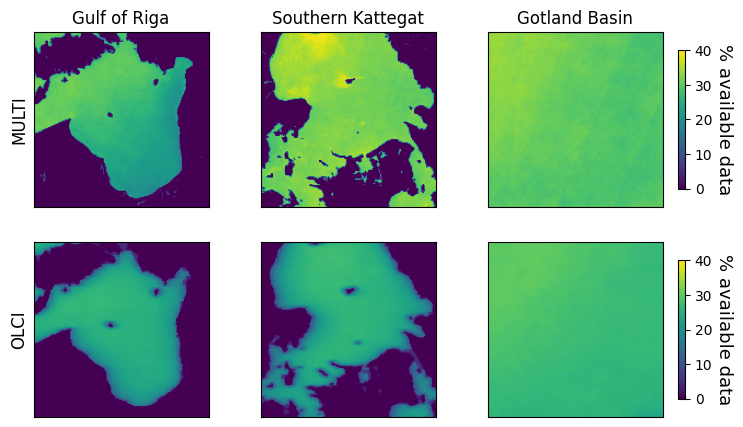

In [ ]:
fig, ax = plt.subplots(2, 3, figsize=(10,5))

ax[0,0].set_title("Gulf of Riga")
ax[0,1].set_title("Southern Kattegat")
ax[0,2].set_title("Gotland Basin")
ax[0,0].set_ylabel("MULTI", fontsize=12)
ax[1,0].set_ylabel("OLCI", fontsize=12)

generate_plots_4(chl_array_multi_RIGA, chl_array_olci_RIGA, 0)
generate_plots_4(chl_array_multi_KTT, chl_array_olci_KTT, 1)
im1, im2 = generate_plots_4(chl_array_multi_GTL, chl_array_olci_GTL, 2)

cbar1 = plt.colorbar(im1, ax=ax[0,:3], shrink=0.79, pad=0.02)
cbar1.set_label('% available data', rotation=270, labelpad=15, fontsize=13)
cbar2 = plt.colorbar(im2, ax=ax[1,:3], shrink=0.79, pad=0.02)
cbar2.set_label('% available data', rotation=270, labelpad=15, fontsize=13)

#plt.tight_layout()

<ipython-input-17-14d5073aabae>:5: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cm = plt.cm.get_cmap('viridis')
<ipython-input-14-cea7ae04fc23>:82: RuntimeWarning: All-NaN slice encountered
  max_pixel_perc_multi = np.nanmax(multi_vals, axis=(0))
<ipython-input-14-cea7ae04fc23>:90: RuntimeWarning: All-NaN slice encountered
  max_pixel_perc_olci = np.nanmax(olci_vals_L3, axis=(0))


Percentage Multi: 24.976008759848053, Olci: 21.55760023991388
Percentage Multi: 30.822199645670587, Olci: 20.496809316643812
Percentage Multi: 30.202158045552935, Olci: 27.610283307540797


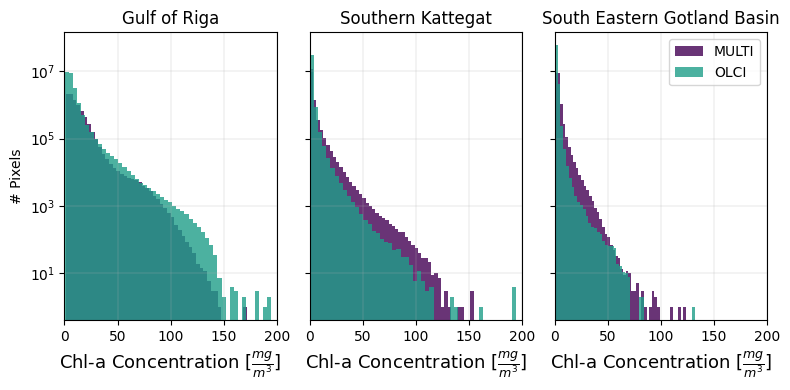

In [ ]:
from matplotlib.colors import ListedColormap
fig, ax = plt.subplots(1, 3, figsize=(8,4), sharex=True, sharey=True)

# Define colormap
cm = plt.cm.get_cmap('viridis')
my_cmap = cm(np.linspace(0,1,10))

# Create new colormap
my_cmap = ListedColormap(my_cmap)

ax[0].set_title("Gulf of Riga")
ax[1].set_title("Southern Kattegat")
ax[2].set_title("South Eastern Gotland Basin")
# ax[0,0].set_ylabel("MULTI", fontsize=12)
# ax[1,0].set_ylabel("OLCI", fontsize=12)

generate_plots_5(chl_array_multi_RIGA, chl_array_olci_RIGA, 0, my_cmap)
generate_plots_5(chl_array_multi_KTT, chl_array_olci_KTT, 1, my_cmap)
generate_plots_5(chl_array_multi_GTL, chl_array_olci_GTL, 2, my_cmap)
ax[0].set_xlabel(r'Chl-a Concentration [$\frac{mg}{m^3}$]', fontsize=13)
ax[1].set_xlabel(r'Chl-a Concentration [$\frac{mg}{m^3}$]', fontsize=13)
ax[2].set_xlabel(r'Chl-a Concentration [$\frac{mg}{m^3}$]', fontsize=13)
ax[0].set_ylabel('# Pixels')
plt.legend()
plt.tight_layout()

<ipython-input-243-8847038949de>:10: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cm = plt.cm.get_cmap('viridis')


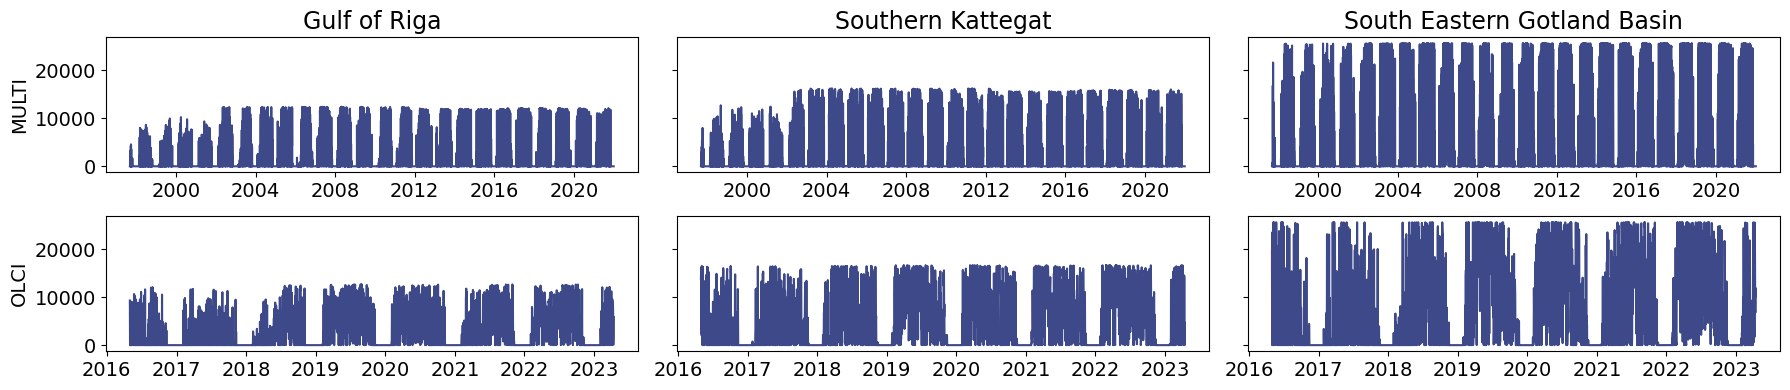

In [ ]:
def available_pixels_plot(multi_val, olci_val, i, time_multi, time_olci, cmap):
  av_pix_multi = np.count_nonzero(~np.isnan(multi_val), axis=(1,2))
  av_pix_olci = np.count_nonzero(~np.isnan(olci_val), axis=(1,2))

  axes[0,i].plot(time_multi,av_pix_multi, color=cmap(2))
  axes[1,i].plot(time_olci, av_pix_olci, color=cmap(2))

fig, axes = plt.subplots(2,3, figsize=(18,4), sharey=True)
# Define colormap
cm = plt.cm.get_cmap('viridis')
my_cmap = cm(np.linspace(0,1,10))

# Create new colormap
my_cmap = ListedColormap(my_cmap)
axes[0,0].set_title("Gulf of Riga", fontsize=17)
axes[0,1].set_title("Southern Kattegat", fontsize=17)
axes[0,2].set_title("South Eastern Gotland Basin", fontsize=17)
axes[0,0].set_ylabel("MULTI", fontsize=14)
axes[1,0].set_ylabel("OLCI", fontsize=14)
available_pixels_plot(chl_array_multi_RIGA, chl_array_olci_RIGA, 0, multi_times, olci_times, my_cmap)
available_pixels_plot(chl_array_multi_KTT, chl_array_olci_KTT, 1, multi_times, olci_times, my_cmap)
available_pixels_plot(chl_array_multi_GTL, chl_array_olci_GTL, 2, multi_times, olci_times, my_cmap)
for a in axes.flatten():
    a.tick_params(axis='both', which='major', labelsize=14)
    a.tick_params(axis='both', which='minor', labelsize=13)
plt.tight_layout()

In [ ]:
olci_times


DatetimeIndex(['2016-05-01', '2016-05-02', '2016-05-03', '2016-05-04',
               '2016-05-05', '2016-05-06', '2016-05-07', '2016-05-08',
               '2016-05-09', '2016-05-10',
               ...
               '2023-04-06', '2023-04-07', '2023-04-08', '2023-04-09',
               '2023-04-10', '2023-04-11', '2023-04-12', '2023-04-13',
               '2023-04-14', '2023-04-15'],
              dtype='datetime64[ns]', length=2541, freq='D')

In [ ]:
multi_times[6814:]

DatetimeIndex(['2016-05-01', '2016-05-02', '2016-05-03', '2016-05-04',
               '2016-05-05', '2016-05-06', '2016-05-07', '2016-05-08',
               '2016-05-09', '2016-05-10',
               ...
               '2021-12-22', '2021-12-23', '2021-12-24', '2021-12-25',
               '2021-12-26', '2021-12-27', '2021-12-28', '2021-12-29',
               '2021-12-30', '2021-12-31'],
              dtype='datetime64[ns]', length=2071, freq='D')